## Multilayer Feedforward Network - Dealing with Missing Data

Michel Kana, DigIntu Tech Ltd, Prague, Czech Republic 

Oliver Mayor, Harvard University, United States

<hr style="height:2pt">

In [5]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import numpy as np
import numpy.random as nd
import pandas as pd
import math
import matplotlib.pyplot as plt

import os
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from IPython.display import display


from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer
from IPython.core.display import HTML

## Part 1: Construct a feed forward neural network
    
In this part of the project we are to construct three feed forward neural networks consisting of an input layer, one hidden layer with 1, 2 and 4 nodes respectively, and an output layer.  The hidden layer uses the sigmoid as the activation function and use a linear  output node. 
We should code the equations from scratch. 

We are given three datasets containing ($x,y$) points where $y=f(x)$:

- In the first dataset, $f(x)$ is a **single step** function (data in`data/step_df.csv`), 
- In the second dataset, $f(x)$ is a **one hump** function (data in `data/one_hump_df.csv`),
- In the third dataset, $f(x)$ is a **two equal humps** function (data in `data/two_hump_df.csv`).


**1.1** Create a plot of each dataset and explore the structure of the data.

**Read and explore the data**

First, we read in and have a look at the three datasets.

In [2]:
# get data
step_df = pd.read_csv("data/step_df.csv")
one_hump_df = pd.read_csv("data/one_hump_df.csv")
two_hump_df = pd.read_csv("data/two_hump_df.csv")

In [3]:
# HTML display helper functions

def html_enclose(tagname, content) -> str:
    return HTML("<{}>{}</{}>".format(tagname, content, tagname))

def html_strong(s : str) -> str:
    return html_enclose("b", s)

def html_hr() -> str:
    return HTML("<hr />")
  
def html_br() -> str:
    return HTML("<br />")

An overview of the three datasets is given below including some statistics.

In [6]:
display(html_strong("Step Dataset"))
display(step_df.head())
display(step_df.describe())
display(html_br())
display(html_br())
display(html_strong("One Hump Dataset"))
display(one_hump_df.head())
display(one_hump_df.describe())
display(html_br())
display(html_br())
display(html_strong("Two Hump Dataset"))
display(two_hump_df.head())
display(two_hump_df.describe())

,x,y
0,-2.762886,0.000706
1,1.108371,-0.000376
2,-0.793581,-0.002845
3,-3.666329,-0.000031
4,8.805071,1.001807


,x,y
count,100.000000,100.000000
mean,1.517285,0.431821
std,4.073068,0.494968
min,-4.861848,-0.002845
25%,-2.009176,-0.000263
50%,0.541288,0.001747
75%,5.247584,0.999669
max,8.805071,1.002055


,x,y
0,3.734197,1.000226
1,6.890217,-0.000877
2,3.330365,0.999072
3,-4.250132,-0.000071
4,3.700311,1.002423


,x,y
count,100.000000,100.000000
mean,1.711190,0.292614
std,3.761073,0.449767
min,-4.988312,-0.002792
25%,-1.322715,-0.000250
50%,1.627919,0.000896
75%,4.317727,0.998469
max,8.880737,1.002423


,x,y
0,-2.637720,0.000288
1,3.808384,0.000326
2,3.121579,0.080294
3,5.713059,1.000351
4,3.975868,0.000362


,x,y
count,100.000000,100.000000
mean,3.887426,0.179185
std,4.927391,0.363343
min,-4.937933,-0.001925
25%,0.043406,-0.000323
50%,3.844823,0.000344
75%,8.164301,0.002528
max,11.988390,1.000706


**Create a plot of each dataset**

The following helper functions create scatter plots of the data.

In [7]:
def setup_figure(nrows = 1, ncols = 1, a_width = 8., a_height = 4.):
    figsize = (ncols * a_width, nrows * a_height)
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize)
    fig.subplots_adjust(left=0.1, right=0.9, top=1.7, bottom=0.1)
    return fig, ax

def xy_scatter(x, y, label, ax, title = "y vs. x", xlabel="x", ylabel="y",
               color="C0", alpha=1.0, fontsize = 16, marker = "o"):
  if len(x) != len(y):
    msg = "x({}) has length {} but y({}) has length {}".format(
        type(x),
        len(x),
        type(y),
        len(y))
    raise Exception(msg)
  
  ax.scatter(x, y, color=color, marker=marker, label=label)
  if not (xlabel is None):
      ax.set_xlabel(xlabel, fontsize=fontsize)
  if not (ylabel is None):
      ax.set_ylabel(ylabel, fontsize=fontsize)
  if not (title is None):
      ax.set_title(title, fontsize=fontsize*1.2)

In [8]:
# some constants
STEP_DATA=0
ONE_HUMP_DATA=1
TWO_HUMP_DATA=2
datasets = [step_df, one_hump_df, two_hump_df]
dataset_names = ['step','one_hump', 'two_hump']
dataset_titles = ["Step Data", "One Hump Data", "Two Hump Data"]

def plot_dataset(df, data_title, ax, color_cycle_start=0):
    color = "C{}".format(color_cycle_start)
    return xy_scatter(df.x, df.y, data_title, ax, title=data_title,
                      xlabel='x', ylabel='y', color=color, marker='*')

# dedicated plot functions for each of the three datasets
# since we will be replotting pretty often
def plot_step(ax, color_cycle_start=3):
    plot_dataset(step_df, dataset_titles[STEP_DATA], ax,
                 color_cycle_start=color_cycle_start)

def plot_one_hump(ax, color_cycle_start=3):
    plot_dataset(one_hump_df, dataset_titles[ONE_HUMP_DATA], ax,
                 color_cycle_start=color_cycle_start)

def plot_two_hump(ax, color_cycle_start=3):
    plot_dataset(two_hump_df, dataset_titles[TWO_HUMP_DATA], ax,
                 color_cycle_start=color_cycle_start)

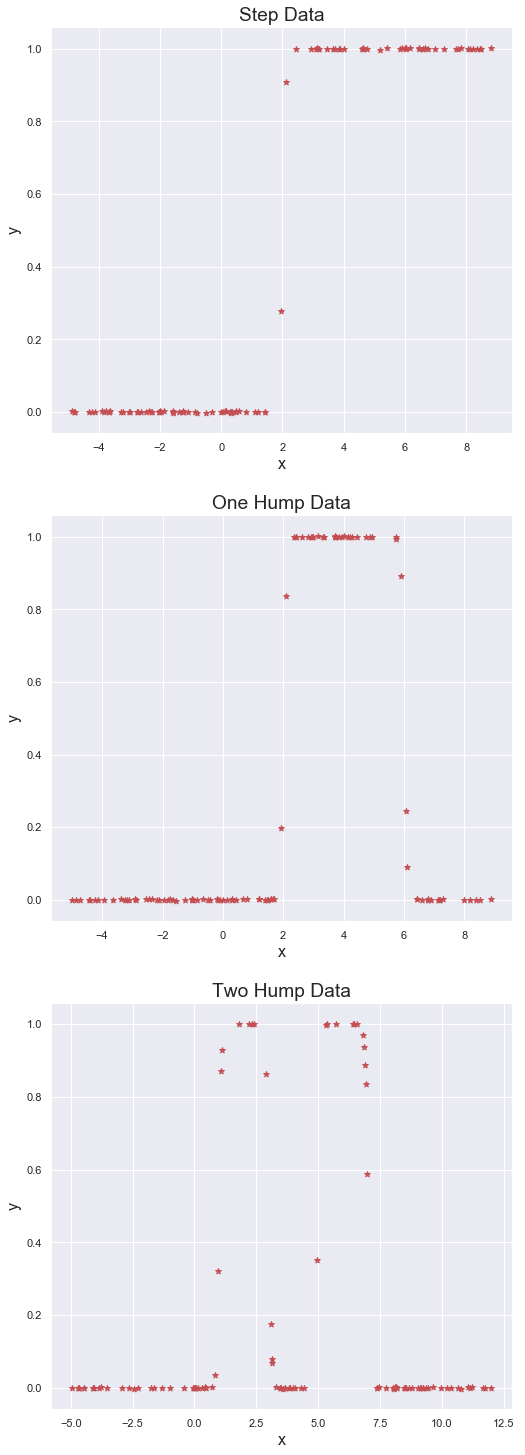

In [9]:
fig, axes = setup_figure(nrows = 3, ncols = 1)

step_ax = plot_step(axes[0])
one_hump_ax = plot_one_hump(axes[1])
two_hump_ax = plot_two_hump(axes[2])

We have 100 observations, 1 predictor x and 1 response variable y in all three cases.

The step data appears to be sampled from a sigmoid function with a steep onset from y=0 starting around x=1.95 The value y=1 is reached around x=2.42.

The one hump data appears to be sampled from a 1-hump function with a steep onset from y=0 starting around x=1.93 The plateau is reached around x=2.4 and maintained up to x=5.73 before droping back to y=0. The one hump data can be visually approximated by sampling a weighted sum of two step function, one being inverted.

The two hump data appears to be sampled from a 2-hump function with a steep onset from y=0 starting around x=0.83 and x=4.96. The plateau is reached around x=1.81 and x=5.71 respectively. The two hump data can be visually approximated by sampling a weighted sum of two 1-hump functions.



In [10]:
# code for investigating x and y
two_hump_df.sort_values(['x'])[two_hump_df.x>0.5].head()

,x,y
80,0.695369,0.002496
74,0.837338,0.035864
69,0.962274,0.320771
9,1.095056,0.870592
41,1.127156,0.927726


In [156]:
step_df.shape, one_hump_df.shape, two_hump_df.shape

((100, 2), (100, 2), (100, 2))


**1.2**  Give values to the weights **manually**, perform a forward pass using the data for the **single step** function and a hidden layer of **one** node, and plot the output from the network, in the same plot as the true $y$ values. Adjust the weigths (again manualy) until the plots match as closely as possible.

Let us construct a network with a single hidden layer. The nature of the data suggests to choose a sigmoid as activation function. The affine transformation is a linear transformation of the predictor values x using a weight and a bias. For this single perceptron, the output y is just the output from the single node.

**Neural network functions**

In [11]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

def affine(x, w, b):
    return w*x + b

def perceptron(x, w, b):
    return sigmoid(affine(x, w, b))

**Plotting functions**

In [12]:
# scatter plot function
def plot_overlay(x, y, label, ax, color="C0", alpha=0.6):
    xy_scatter(x, y, label, ax, color=color, alpha=alpha, marker = "o")

In [13]:
# overlay a plot of true data and network output
# parameters
#  n: number of layers
#  x: input
#  yy: network output
#  plot_function: function for plotting true data from single step, one hump and two humps datasets 
def plot_network_output(n, x, yy, w, b, ax, plot_function, plot_title,
                        alpha=0.5, fontsize=16):
    plot_function(ax)
    plot_overlay(x, yy, "Perceptron", ax, color="C4", alpha=alpha)
    data_desc = ax.get_title()
    ax.set_title(plot_title, fontsize=fontsize)
    ax.legend(loc="best")
    
# plot the output for 1 layer network
def plot_1n_output(x, yy, w, b, ax, plot_function, data_desc=""):
    plot_title = "1-node network approximation of {}\nw={} b={}".format(
        data_desc, w, b)
    plot_network_output(1, x, yy, w, b, ax, plot_function, plot_title)

# plot for multiple layers network
def plot_1n_multiples(x, yys, ws, bs, axes, plot_function, data_desc="",
                      offset=0):
    for i in range(offset, len(yys)):
        plot_1n_output(x, yys[i], ws[i], bs[i], axes[i-offset], plot_function,
                       data_desc=data_desc)

**Adjusting weights and bias using single step data and one node **

We choose possible weight and bias values as a best guess. The plots below shows six attemps made to manually adjust until the network output matches the single step data.

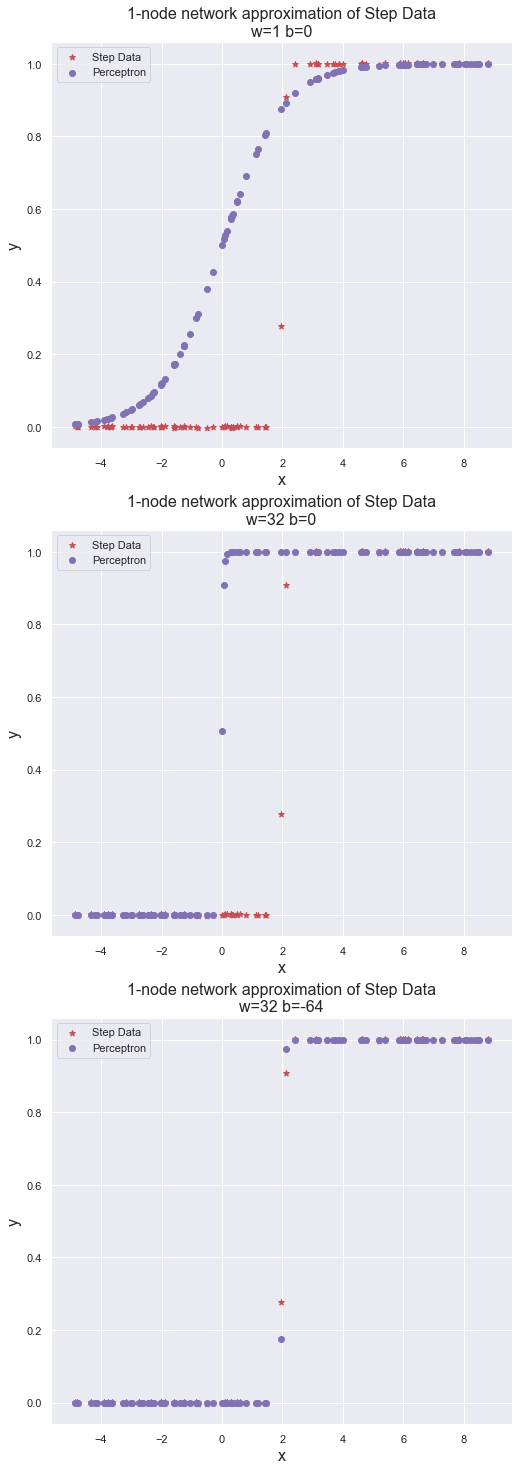

In [14]:
## set weights
offset = 0
yy_step1n = []
ws = [ 1, 32, 32]
bs =  [-0, 0, -64]


## get predictions
for i in range(offset, len(ws)):
    yy_step1n.append(perceptron(step_df.x, ws[i], bs[i]))

## plot 
fig, axes = setup_figure(nrows = len(yy_step1n) - offset, ncols = 1)
plot_1n_multiples(step_df.x, yy_step1n, ws, bs, axes, plot_step,
                  data_desc=dataset_titles[STEP_DATA], offset=offset)

## save selected weights for later
hidden_params = {
    STEP_DATA : {
      'w' :[ws[-1]],
      'h' : [bs[-1]],
      'yy' : yy_step1n[-1],
      'n' : 1,
    }
}

In [15]:
display(html_enclose("p",("The weight {} and bias {} offer the closest match between" +
                  "the 1-layer network output and single step data.").format(
    hidden_params[0]['w'][0],
    hidden_params[0]['h'][0])))

**1.3** Do the same for the **one hump** function data, this time using a hidden layer consisting of **two** nodes.

We know investigate a neural network wth one hidden layer consisting of two nodes that would fit the one-hump data.

**Neural network functions**

In [16]:
# function for generating the output of a multi-layer network
# parameters
#  n: number of layers
#  x: input vector
#  w: weight vector
#  b: bias vector
#  w_out: output weight
#  b_out: output biais
def perceptron_layer(n, x, w, b, w_out=1, b_out=0):
    y_out = np.zeros(len(x))
    for i in range(0,n):
        result = np.array(perceptron(x, w[i], b[i]))
        y_out += result
    return  affine(y_out, w_out, b_out)

# function for visualizing the network output vs true data
# for a given weight and bias
def plot_nn_output(x, yy, w, b, ax, plot_function, w_out = 1, b_out = 0, n=2,
                   data_desc=""):
    plot_title = "{}-node network approximation of {}\nw={} b={}".format(
        n, data_desc, w, b)
    # overlay a plot of true data and network output
    plot_network_output(n, x, yy, w, b, ax, plot_function, plot_title)

# function for visualizing the network output vs true data for an array of weights and biass 
def plot_nn_multiples(x, yys, ws, bs, axes, plot_function, w_out = 1,
                      b_out = 0, data_desc="", offset=0, n=2):
    # todo - remove
    #print("step_df.x: ", type(step_df.x), step_df.x.shape)
    #print("yy: ", type(yy_), yy_.shape)
    for i in range(offset, len(yys)):
        plot_nn_output(x, yys[i], ws[i], bs[i], axes[i+offset], plot_function,
                       w_out=w_out,
                       b_out=b_out,
                       n=n,
                       data_desc=data_desc)

**Adjusting weights and bias using one hump data and two nodes **

We start with a neural network with one single node with a sigmoid activation function. We choose possible weight and bias values as a best guess. The plots below shows four attemps made to manually adjust until the network output matches the first slope of the one hump data.

In [17]:
# function for plotting the output of 1-layer network with a single node with a sigmoid activation function
#  parameters:
#   x: input
#   weights: vector of weights
#   biases: vector of biases
def compare_multiple_weights_biases_1n(x, weights, biases,
                                       plot_function=plot_step, data_desc="",
                                       a_width=8, a_height=4):
  if len(weights) != len(biases):
    msg = ("weights ({}) different length ({})" +
           " from biases ({}) length ({})").format(
        type(weights),
        len(weights),
        type(biases),
        len(biases),)
    raise Exception(msg)
  
  fig, axes = setup_figure(nrows=len(weights), ncols=1,
                           a_width=a_width, a_height=a_height)
  yys = []
  for i in range(len(weights)):
    yys.append(perceptron(x, weights[i], biases[i]))
  # handle length one case
  if len(yys) == 1:
    axes = [axes]
  plot_1n_multiples(x, yys, weights, biases, axes, plot_function, offset=0,
                   data_desc=data_desc)
  return fig, axes


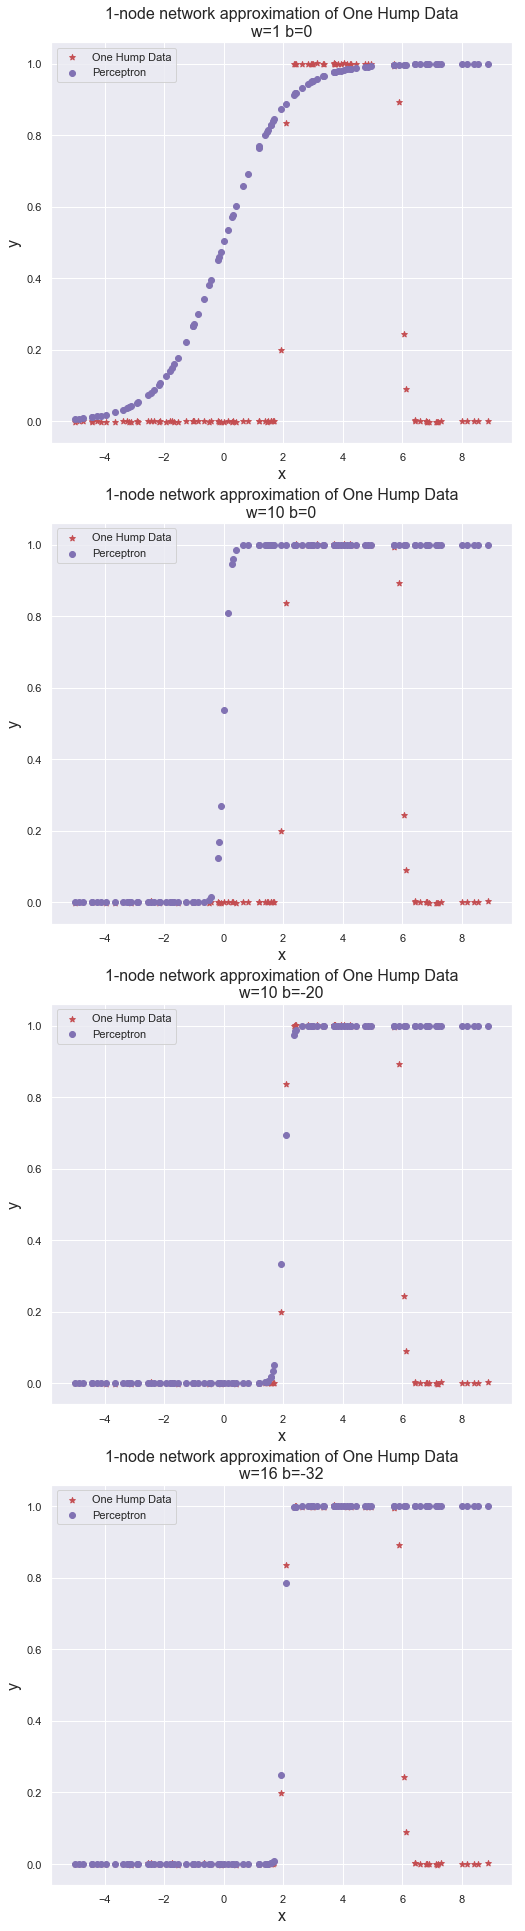

In [18]:
# One hump

## try out for one sigmoid at a time:

### set weights
offset = 0
yy_one_hump_left = []
ws_left = [ 1, 10, 10, 16]
bs_left =  [ 0, 0, -20, -32]
for i in range(offset, len(ws_left)):
    yy_one_hump_left.append(perceptron(one_hump_df.x, ws_left[i], bs_left[i]))

## plot 
fig, axes = setup_figure(nrows = len(yy_one_hump_left) - offset, ncols = 1)
plot_1n_multiples(one_hump_df.x, yy_one_hump_left, ws_left, bs_left,
                  axes, plot_one_hump, offset=offset,
                  data_desc=dataset_titles[ONE_HUMP_DATA])

We continue with a neural network with one single node and a sigmoid activation function. We choose possible weight and bias values as a best guess. The plots below shows three attemps made to manually adjust until the network output matches the second slope of the one hump data.

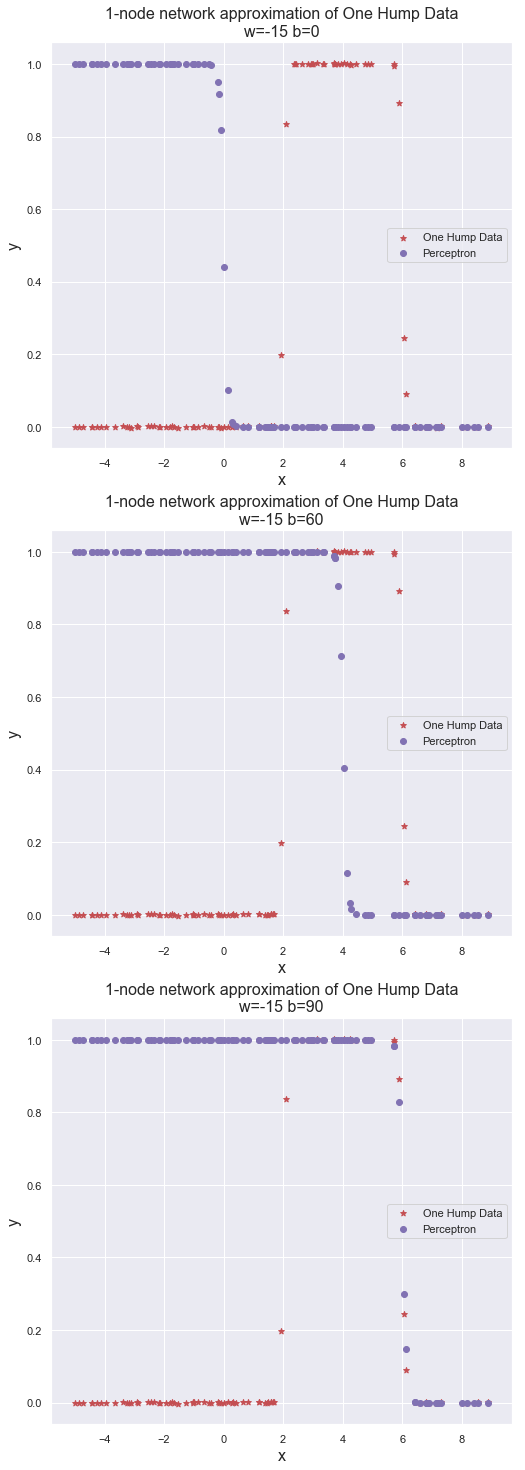

In [19]:
# One hump - second slope

## try out for one sigmoid at a time:

### set weights
offset = 0
yy_one_hump_right = []
ws_right = [ -15, -15, -15]
bs_right =  [0, 60, 90]
for i in range(offset, len(ws_right)):
    yy_one_hump_right.append(perceptron(one_hump_df.x,
                                        ws_right[i], bs_right[i]))

## plot 
fig, axes = setup_figure(nrows = len(yy_one_hump_right) - offset, ncols = 1)
plot_1n_multiples(one_hump_df.x, yy_one_hump_right, ws_right, bs_right,
                  axes, plot_one_hump, offset=offset,
                 data_desc=dataset_titles[ONE_HUMP_DATA])

Finally we use the optimal weights obtained above to create a neural network with two nodes and a sigmoid activation function. We now choose possible weight and bias values for the output layer as a best guess. The plots below shows two attemps made to manually adjust until the network output matches the whole one hump data.

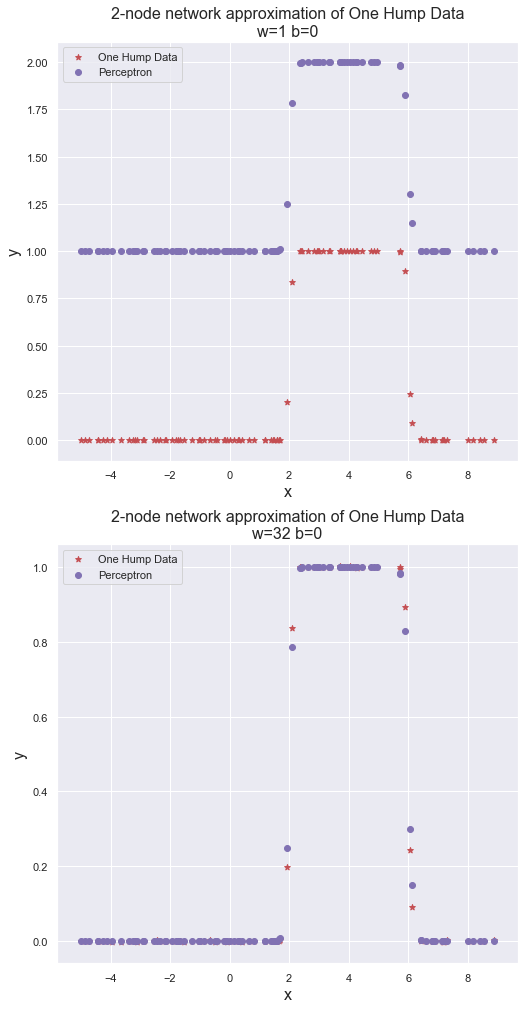

In [20]:
# One hump

## use combination of weights from individual sigmoids

## use combination of weights from individual sigmoids
ws_best = (ws_left[-1], ws_right[-1])
bs_best = (bs_left[-1], bs_right[-1])
yy_one_hump_2n = []

w_outs = [
  1,
  1,]
b_outs = [
  0,
  -1,]

## get predictions
for i in range(offset, len(w_outs)):
    result = perceptron_layer(2, one_hump_df.x, ws_best, bs_best, w_outs[i], b_outs[i])
    yy_one_hump_2n.append(result)

## plot 
fig, axes = setup_figure(nrows = len(yy_one_hump_2n) - offset, ncols = 1,
                         a_width = 8., a_height = 4.)
plot_nn_multiples(one_hump_df.x, yy_one_hump_2n, ws, bs, axes, plot_one_hump,
                 data_desc=dataset_titles[ONE_HUMP_DATA])

## save selected weights for later
hidden_params[ONE_HUMP_DATA] = {
    'name' : dataset_names[STEP_DATA],
    'data_desc' : dataset_titles[ONE_HUMP_DATA],
    'w' : ws_best,
    'h' : bs_best,
    'yy' : yy_one_hump_2n[-1],
    'n' : 2,
}

In [21]:
display(html_enclose("p",(
    "The input weight W_in = {}, input bias b_in = {}, " +
    "output weight W_out = {} and output bias b_out = {} offer the " +
    "closest match between the 1-layer network with two nodes and " +
    "one-hump data.").format(
         hidden_params[ONE_HUMP_DATA]['w'],
         hidden_params[ONE_HUMP_DATA]['h'],
         w_outs,
         b_outs)))

**1.4** Do the same for the **two hump** function data but this time increase the number of hidden nodes to **four**.  

We now investigate a neural network with one hidden layer consisting of four nodes that would fit the two-hump data.

**Adjusting weights and bias using two-hump data and four nodes **

We start with a neural network with one single node with a sigmoid activation function. We choose possible weight and bias values as a best guess. The following plots below shows three iterative attempts, to manually adjusting the weights until the network output matches the left slope of the first hump.

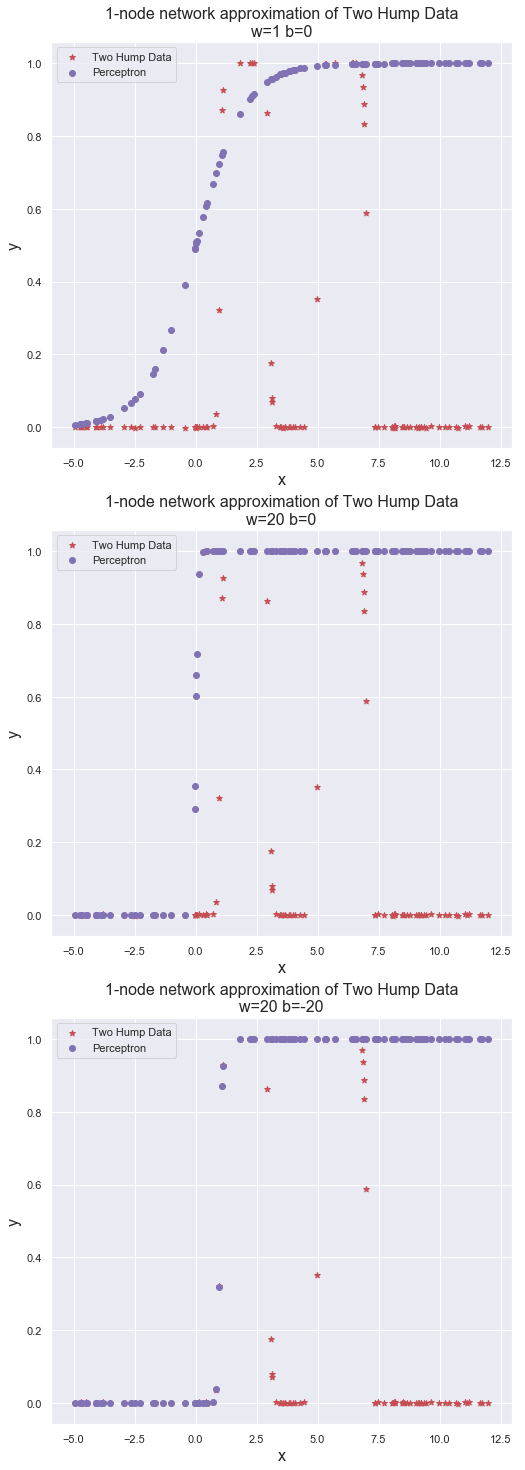

In [22]:
display(html_enclose("h3", "First sigmoid"))
ws1 = [1, 20, 20]
bs1 = [0, 0, -20]
fig, ax = compare_multiple_weights_biases_1n(two_hump_df.x, ws1, bs1,
                                plot_function=plot_two_hump,
                                data_desc=dataset_titles[TWO_HUMP_DATA])


We followed a similar iterative process with the second, third, and fourth sigmoids. For brevity, only the final results appear in the plots below.

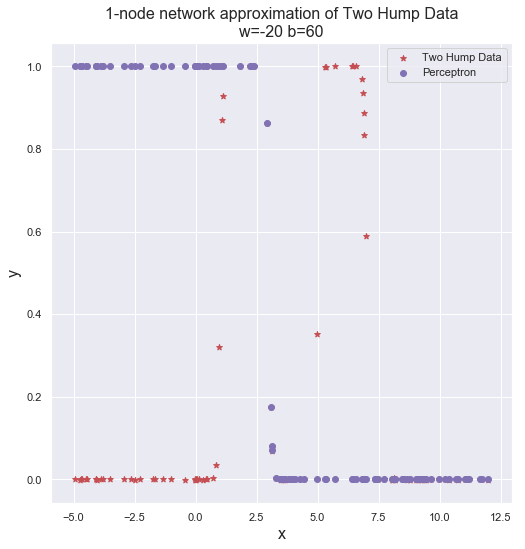

In [23]:
display(html_enclose("h3", "Second sigmoid"))
ws2 = [-20]
bs2 = [60]
fig, ax = compare_multiple_weights_biases_1n(two_hump_df.x, ws2, bs2,
                                plot_function=plot_two_hump,
                                data_desc=dataset_titles[TWO_HUMP_DATA])


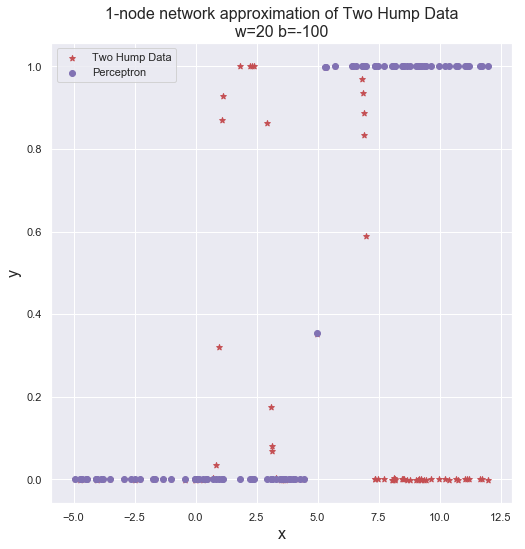

In [24]:
display(html_enclose("h3", "Third sigmoid"))
ws3 = [20]
bs3 = [-100]
fig, ax = compare_multiple_weights_biases_1n(two_hump_df.x, ws3, bs3,
                                plot_function=plot_two_hump,
                                data_desc=dataset_titles[TWO_HUMP_DATA])

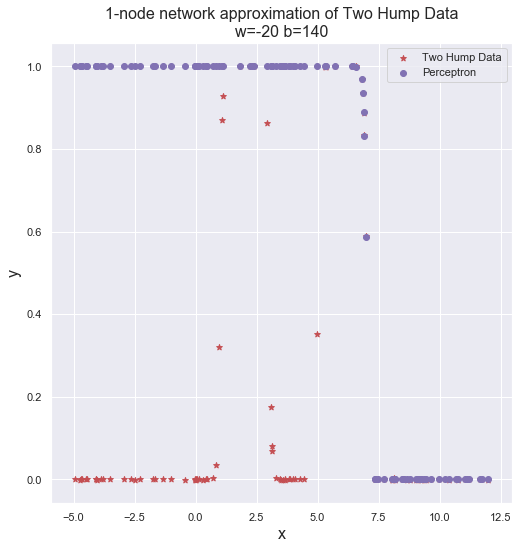

In [25]:
display(html_enclose("h3", "Fourth sigmoid"))
ws4 = [- 20]
bs4 = [140]
fig, ax = compare_multiple_weights_biases_1n(two_hump_df.x, ws4, bs4,
                                plot_function=plot_two_hump,
                                data_desc=dataset_titles[TWO_HUMP_DATA])

Using the manually tuned weights and biases for each individual sigmoid, we use them in the combined network output. In the final step, we tune the output transformation.

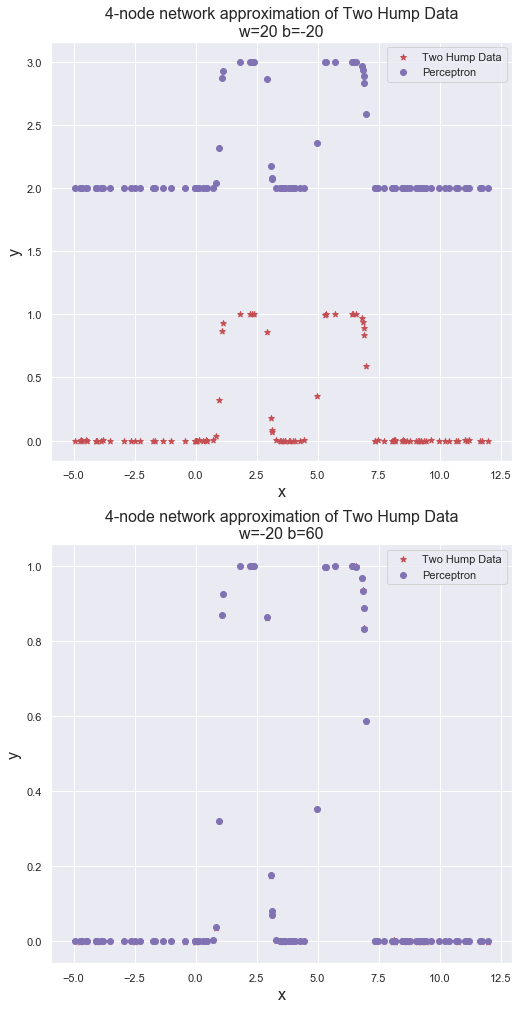

In [26]:
display(html_enclose("h3", "Tuning the linear output layer weight and bias"))
## set weights
offset = 0
ws = [
    ws1[-1],
    ws2[-1],
    ws3[-1],
    ws4[-1]
]

bs = [
    bs1[-1],
    bs2[-1],
    bs3[-1],
    bs4[-1],
]
yy_two_hump_4n = []

w_outs = [1, 1]
b_outs = [0, -2]

## get predictions
nplots = len(w_outs)
for i in range(offset, nplots):
    result = perceptron_layer(4, two_hump_df.x, ws, bs, w_out=w_outs[i],
                              b_out=b_outs[i])
    yy_two_hump_4n.append(result)

## plot
fig, axes = setup_figure(nrows = nplots - offset, ncols = 1)
plot_nn_multiples(two_hump_df.x, yy_two_hump_4n, ws, bs, axes, plot_two_hump,
             offset=offset, n=4, data_desc=dataset_titles[TWO_HUMP_DATA])

## save selected weights for later
hidden_params[TWO_HUMP_DATA] = {
    'yy' : yy_two_hump_4n[-1],
    'w' : ws,
    'h' : bs,
    'n' : 4,
}

In [27]:
display(html_enclose("p",("To summarize, the manually selected hidden layer weights" +
                        " W_in = {},  the manually selected hidden layer biases B_in = {}, "  +
                        "combined with the linear output layer weight w_out = {} " +
                         "and output bias b_out = {} offer " +
                        "a very close match between the 1-layer network with four " +
                        "nodes and two-hump data.").format(
    hidden_params[TWO_HUMP_DATA]['w'],
    hidden_params[TWO_HUMP_DATA]['h'],
    w_outs,
    b_outs)))

But while this may appear sufficient graphically, there is no guarantee that this is these are the optimum values.


**1.5** Choose the appropriate loss function and calculate and report the loss from all three cases. Derive the gradient of the output layer's weights for all three cases (step, one hump and two humps). Use the weights for the hidden layers we found in the previous question and perform gradient descent on the weights of this layer (output layer). What is the optimised weight value and loss we obtained? How many steps did we take to reach this value? What is the threshold value we used to stop? 

Keeping the manually selected weights and biases for the hidden layer, we will attempt gradient descent to optimize the weight and bias of the linear output layer.

The first issue is: what loss function should we use to calculate the optimization? Since the output layer is a linear transformation, one obvious candidate is mean square error.

In [28]:
# loss functions: mean square error and gradient

def mse(y, y_pred):
  # Returns the mean square error given a set of actual and predicted values.
  if y.shape[0] != y_pred.shape[0]:
    msg = "[mse] : Mismatch: size({}), size({})".format(
        y.shape[0], y_pred.shape[0])
    raise Exception(msg)
  return np.mean((y_pred - y)**2) # sum then divide by 1/n

def grad_mse(x, y, w_out, b_out, n, ws_h, bs_h, epsilon = None):
  # returns the gradient of the Mean Square Error
  
  # get hidden layer output without any transformation
  # (considered a constant in the differentiation)
  h = perceptron_layer(n, x, ws_h, bs_h)
  
  dw_terms = 2*h*(w_out*h + b_out - y)
  db_terms = 2*(w_out*h + b_out - y)
  return np.mean(dw_terms), np.mean(db_terms) # sum then divide by 1/n

We usually see maximum likelihood in combination with sigmoid functions, which we have used as the activation functions in the hidden layer. However, the way the network combines the values causes it to fall outside $(0,1)$, the domain of likelihood function (and thus the negative log-likelihood function, which we would use in practice.)

However, it is possible to first map the range of the network's output onto the domain of the likelihood function. We can do this by passing the output through a sigmoid.

Below we define the loss function sigmoid-transformed negative log likelihood and its respective gradient.

In [29]:
def epsilon_neighbors(epsilon = 10**-9, n = 1):
    # returns an n-tuple of random numbers from
    # (-epsilon, epsilon)
    if n is None:
        print("[epsilon_neighbors] Warning: n was set to none")
    elif n < 1:
        msg = "n needs to be greater than one: n={}".format(n)
        raise Exception(msg)
    if epsilon >= 1:
        msg = "Epsilon should be << one; provided value: {}".format(
            epsilon)
        raise Exception(msg)
        
    sample = None
    if n == 1:
        sample = (np.random.random_sample()*2 - 1)*epsilon
    else:
        sample = (np.random.random_sample((n, ))*2 - 1)*epsilon
    return sample

In [30]:
def sigmoid_log_loss(y, y_pred):
    p = sigmoid(y_pred)
    # Negative log likelihood of observations
    # first term: y*log(p), p = y_pred
    i = 0
    while np.sum(p <= 0) > 0:
      i += 1
      p += np.abs(epsilon_neighbors(n=p.shape[0]))
    l_term1 = np.sum(y*np.log(p))
    # second term: (1-y)*log(1 - p), p = sigmoid(y_pred)
    while np.sum((1-p) <= 0) > 0:
      i += 1
      p -= np.abs(epsilon_neighbors(n=p.shape[0]))
    l_term2 = np.sum((1 - y)*np.log((1- p)))
    if i > 50:
      print("Warning: jittered epsilons {} times!".format(i))
    # sum of terms
    return - (l_term1 + l_term2)
  
def grad_sigmoid_log_loss(x, y, w_out, b_out, n, ws_h, bs_h,
                          epsilon = 10**-9):
    # get hidden layer output without any transformation
    # (considered a constant in the differentiation)
    h = sigmoid(perceptron_layer(n, x, ws_h, bs_h))
    
    # partial derivative with respect to w_out
    dLa_dw = h*y/(w_out*h + b_out - 1)/(w_out*h + b_out)
    dLb_dw = -h/(w_out*h + b_out -1)
    dL_dw = dLa_dw + dLb_dw
    
    # partial derivative with respect to b_out
    dLa_db = y/(w_out*h + b_out - 1)/(w_out*h + b_out)
    dLb_db = -1/(w_out*h + b_out -1)
    dL_db = dLa_db + dLb_db
    return (-np.sum(dL_db), -np.sum(dL_dw))

As a third possibility, we will also define the Mean Average Error, or L1, as a potential loss function.

In [31]:
def mae(y, y_pred):
  return np.sum(np.absolute(y_pred - y))

def grad_mae(x, y, w_out, b_out, n, ws_h, bs_h, epsilon = None):
  # get hidden layer output without any transformation
  # (considered a constant in the differentiation)
  h = perceptron_layer(n, x, ws_h, bs_h)
  
  # screen for division by zero
  dw_denom_input = w_out*h + b_out - y
  # if it contains at least one zero, add some random epsilons
  if np.sum(dw_denom_input == 0) > 0:
    dw_denom_input += epsilon_neighbors(n=dw_denom_input.shape[0])
  
  dw_terms = h*(w_out*h + b_out - y)/np.abs(dw_denom_input)

  dh_denom_input = w_out*h + b_out - y
  # if it contains at least one zero, add some random epsilons
  if np.sum(dw_denom_input == 0) > 0:
    dw_denom_input += epsilon_neighbors(n=dw_denom_input.shape[0])
  dh_terms = w_out*(w_out*h + b_out - y)/np.abs(dh_denom_input)
  
  return np.sum(dw_terms), np.sum(dh_terms)

Next we will define the general procedures for gradient descent. We will include an option to receive a record of loss at every step so we can analyze the performance of different loss functions and parameters.


In [32]:
def loss(y, y_pred, loss_function=mse):
  return loss_function(y, y_pred)

def grad(x, y, w_out, b_out, n, ws_h, bs_h,
         grad_function=grad_mse, epsilon = 10**-9):
  # wrapper function, returning the tuple (gradient)
  return grad_function(x, y, w_out, b_out, n, ws_h, bs_h, epsilon=epsilon)
  

def grad_descent(x : np.array, y : np.array,
                 w_out0 : float,
                 b_out0 : float,
                 n : int,
                 ws_h : list,
                 bs_h : list,
                 loss_function=mse,
                 grad_function=grad_mse,
                 l_rate = 0.01,
                 threshold = 10**-5,
                 max_iter = 10000,
                 epsilon=10**-9,
                 trace=False):
  # start at initial point
  # get value (d_w, d_h) for gradient
  # step in opposite direction from gradient, i.e. (w_i - d_w*l_rate, h_i - d_h*l_rate)
  # check if within threshold
  steps = 0
  w_i = w_out0
  b_i = b_out0
  
  y_pred = perceptron_layer(n, x, ws_h, bs_h, w_i, b_i)
  current_loss = loss(y, y_pred, loss_function=loss_function)
  if trace:
      losses = [current_loss]
  
  # let l=loss, t=threshold to test against
  within_threshold = lambda l, t : (l < t)

  while not within_threshold(current_loss, threshold) and steps < max_iter:
    (d_w, d_b) = grad(x, y, w_i, b_i, n, ws_h, bs_h,
                      grad_function=grad_function, epsilon=epsilon)
    # we want to move in the opposite direction
    (w_i, b_i) = (w_i - d_w*l_rate, b_i - d_b*l_rate)

    steps += 1
    y_pred = perceptron_layer(n, x, ws_h, bs_h, w_i, b_i)
    current_loss = loss(y, y_pred, loss_function)
    
    # if trace enabled, logs current loss
    if trace:
      losses += [current_loss]
    
    # check for errors
    if current_loss < 0:
      msg = ("grad_descent error: loss {} is < 0!" +
             " check the loss function.").format(current_loss)
      raise Exception(msg)
    elif np.isnan(current_loss):
      msg = ("grad_descent error: loss is {} " +
             "for epsilon={}! check the loss function.").format(
          current_loss, 10**-9)
      raise Exception(msg)
  
  if trace:
    result = (w_i, b_i, current_loss, steps, tuple(losses))
  else:
    result = (w_i, b_i, current_loss, steps)
  return result
  



And here are a few utilitizes to report the results of the gradient descent, and optionally to plot loss for each step.

In [33]:
def plot_loss(ax, losses : np.array, threshold : float,
              opt_variant="", unit_name="", loss_function_name="",
              learning_rate=0, other_desc="", fontsize=16):
  # creates a plot of loss for each step of gradient descent
  steps = list(range(0, len(losses))) # x-axis

  # build plot title  
  loss_desc = "Loss"
  title = ""
  if len(opt_variant):
    title = optimization_variant
  else:
    title = "Gradient descent optimization"
  if len(unit_name):
    title += " on {} layer weights".format(unit_name)
  if len(loss_function_name):
    loss_desc = loss_function_name
    title += "\n{} loss".format(loss_desc)
  if learning_rate:
    title += ", learning rate={}".format(learning_rate)
  if len(other_desc):
    title += ", {}".format(initial_values)
  title += ", threshold: {}".format(threshold)
  
  # labels and formatting for plot
  xaxis_label = "Steps"
  yaxis_label = "Loss"
  if len(losses) <= 150:
    fmt_str = "o-"
  else:
    fmt_str = "-"
  
  # plot
  ax.plot(np.array(steps), np.array(losses), fmt_str, label=loss_desc)
  ax.set_xlim(-steps[-1]*0.02, steps[-1]*1.02)
  ax.set_xlabel(xaxis_label, fontsize=fontsize)
  ax.set_ylabel(yaxis_label, fontsize=fontsize)
  ax.set_title(title, fontsize=fontsize)
  ax.legend(loc="best", fontsize=fontsize*.8)

In [34]:
def show_opt_info(x, y, dataset_plot, ws, bs, w_out0, b_out_0,
                  axes, title, offset=0,
                  loss_function=mse,
                  grad_function=grad_mse,
                  learning_rate=10**-2, threshold=10**-4,
                  max_iter=10**3, hidden_layer_size=1, plot_steps=False):
  display(HTML("<h3>{}</h3>".format(title)))
  # do gradient descent
  w_out, b_out, network_loss, steps, losses = grad_descent(
      x,
      y,
      w_out0,
      b_out0,
      hidden_layer_size,
      ws,
      bs,
      loss_function=loss_function,
      grad_function=grad_function,
      l_rate = learning_rate, # learning rate
      threshold = threshold, # threshold
      max_iter=max_iter, # maximum iterations before stopping
      trace = plot_steps # save sequence of losses if we want to plot loss vs step #
  )
  display(HTML("<br /><em>Gradient Descent Results</em>"))
  table_data = {
       "Steps" : [steps],
      "Network Loss" : [network_loss],
      "Optimized b_out" : [b_out],
      "Optimized w_out": [w_out],
      "Threshold" : [threshold],
      "Learning Rate" : [learning_rate],
  }
  table_df = pd.DataFrame(data=table_data)
  display(table_df.T)
  yy = perceptron_layer(hidden_layer_size, x, ws, bs, w_out=w_out, b_out=b_out)
  plot_nn_output(step_df.x,
                    yy,
                    ws,
                    bs,
                    axes[0+offset],
                    dataset_plot,
                    w_out = w_out,
                    b_out = b_out,
                    n=hidden_layer_size)
  # only plot loss vs step # if trace is turned on
  if plot_steps:
    plot_loss(axes[1+offset],
              losses, 10**-5,
              unit_name="linear output",
              learning_rate=10**-2)


First, we will look at optimizing the output layer's weight and bias for an estimation of the Step dataset.

As a first step, we will try optimizing with MSE as the loss function, keeping the maximum number of steps relatively low.

,0
Steps,1000.000000
Network Loss,0.000145
Optimized b_out,0.001359
Optimized w_out,0.997546
Threshold,0.000010
Learning Rate,0.010000


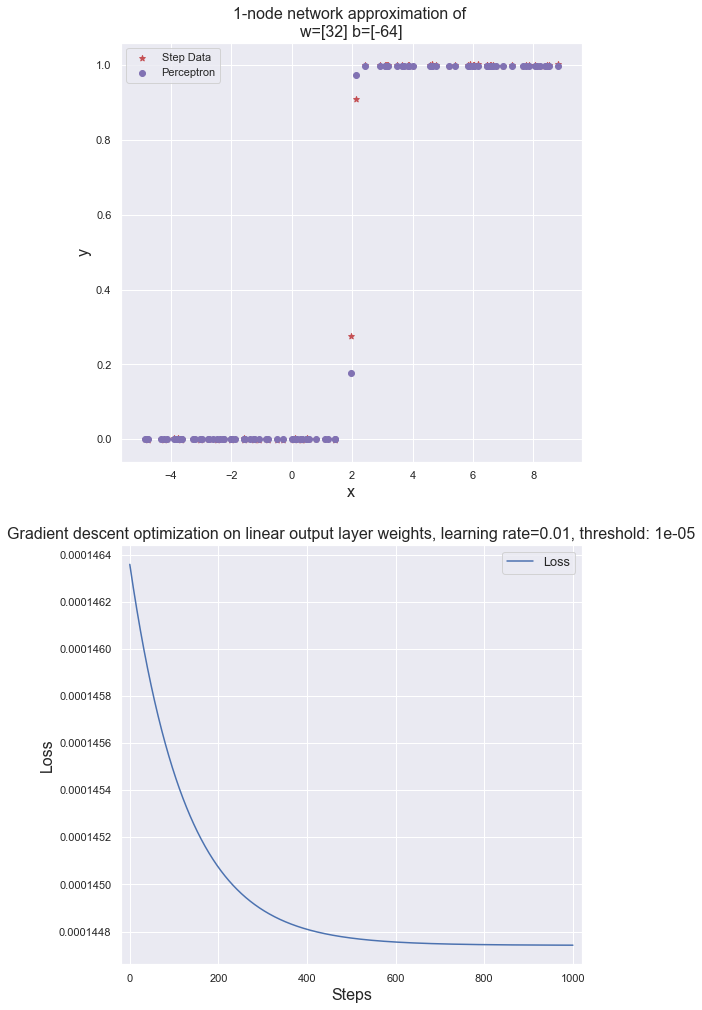

In [35]:
# step dataset / 1-node network : mse

fig, axes = setup_figure(2, 1)

## initial linear output weights
w_out0 = 1
b_out0 = 0
hidden_nodes = 1

## gradient descent parameters
learning_rate_ = 10**-2
threshold_ = 10**-5
max_iter_ = 10**3

show_opt_info(
    datasets[STEP_DATA].x, # x,
    datasets[STEP_DATA].y, # y,
    plot_step, # dataset_plot
    hidden_params[STEP_DATA]['w'], # ws,
    hidden_params[STEP_DATA]['h'], # bs,
    w_out0,
    b_out0,
    axes,
    "<em>{} vs Network Output</em><br/>".format(dataset_titles[STEP_DATA]) +
    "{}-node hidden layer (manually tuned weights)<br />".format(hidden_nodes) +
    "Linear output layer (optimized model MSE)", # title,
    learning_rate=learning_rate_,
    threshold=threshold_,
    max_iter=max_iter_,
    hidden_layer_size=hidden_nodes,
    plot_steps=True
)

Even with the gradient descent to 1000 steps, it does fairly well estimating the true data, except for the two points in the middle of the graph.

Looking at the plot of loss versus step number, we can see that the loss decreases rapidly in the first 300 or so steps. After this, the decrease levels out.

It may take a much longer time for gradient descent to find a minimum under our threshold, or to improve the output significantly.

Now, we will look at how MAE loss does for the first 1000 steps with the same parameters.

,0
Steps,1000.000000
Network Loss,27.429523
Optimized b_out,-0.373648
Optimized w_out,1.514819
Threshold,0.000010
Learning Rate,0.010000


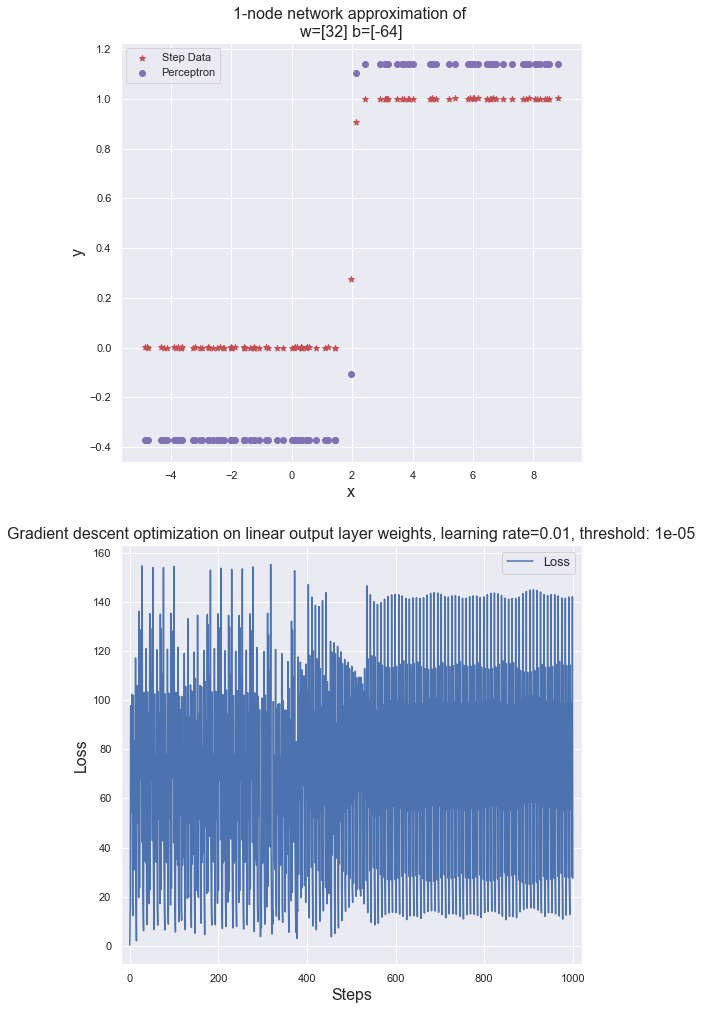

In [36]:
# step dataset / 1-node network : mae

fig, axes = setup_figure(2, 1)

## initial linear output weights
w_out0 = 1
b_out0 = 0
hidden_nodes = 1

## gradient descent parameters
learning_rate_ = 10**-2
threshold_ = 10**-5
max_iter_ = 10**3

show_opt_info(
    datasets[STEP_DATA].x, # x,
    datasets[STEP_DATA].y, # y,
    plot_step, # dataset_plot
    hidden_params[STEP_DATA]['w'], # ws,
    hidden_params[STEP_DATA]['h'], # bs,
    w_out0,
    b_out0,
    axes,
    "<em>{} vs Network Output</em><br/>".format(dataset_titles[STEP_DATA]) +
    "{}-node hidden layer (manually tuned weights)<br />".format(hidden_nodes) +
    "Linear output layer (optimized model MAE)", # title,
    loss_function=mae,
    grad_function=grad_mae,
    learning_rate=learning_rate_,
    threshold=threshold_,
    max_iter=max_iter_,
    hidden_layer_size=hidden_nodes,
    plot_steps=True
)

While gradient descent with MAE loss does obtain the correct shape of the graph after 1000 steps, the scale is wrong.

Looking at the loss vs steps graph, it is hard to tell whether the loss will converge towards a minimum with additional steps. With this in mind, MAE seems to be a worse choice than MSE.

,0
Steps,1000.000000
Network Loss,1150.883955
Optimized b_out,20.539045
Optimized w_out,46.898987
Threshold,0.000010
Learning Rate,0.010000


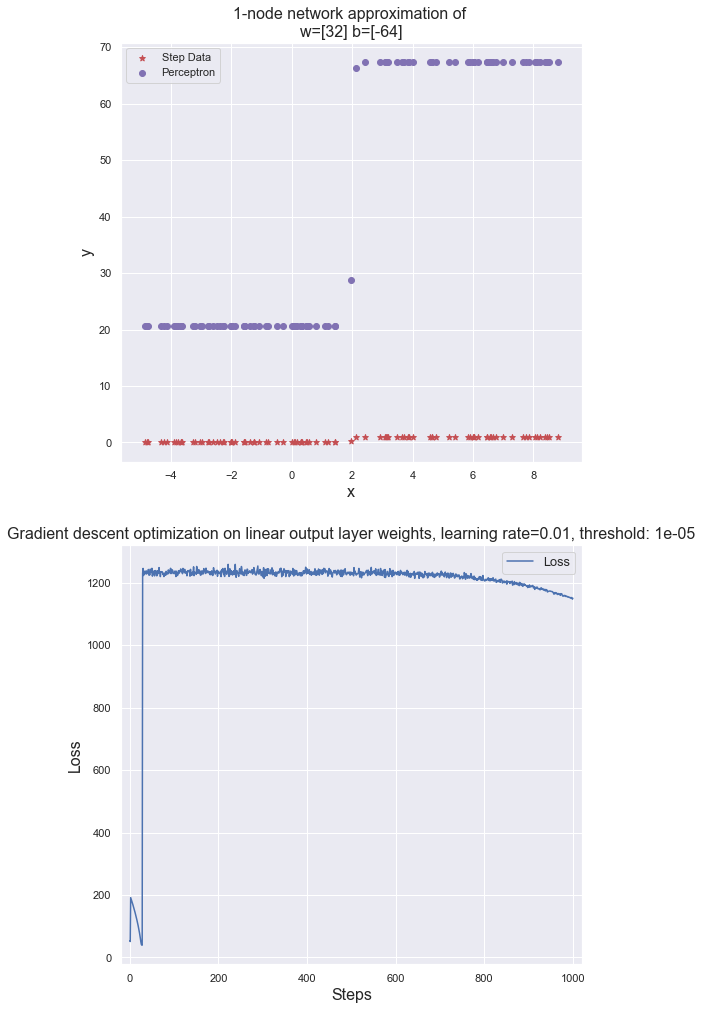

In [37]:
# step dataset / 1-node network : sigmoid-log-loss

fig, axes = setup_figure(2, 1)

## initial linear output weights
w_out0 = 1
b_out0 = 0
hidden_nodes = 1

## gradient descent parameters
learning_rate_ = 10**-2
threshold_ = 10**-5
max_iter_ = 10**3

show_opt_info(
    datasets[STEP_DATA].x, # x,
    datasets[STEP_DATA].y, # y,
    plot_step, # dataset_plot
    hidden_params[STEP_DATA]['w'], # ws,
    hidden_params[STEP_DATA]['h'], # bs,
    w_out0,
    b_out0,
    axes,
    "<em>{} vs Network Output</em><br/>".format(dataset_titles[STEP_DATA]) +
    "{}-node hidden layer (manually tuned weights)<br />".format(hidden_nodes) +
    "Linear output layer (optimized model: Sigmoid-Log Loss)", # title,
    loss_function=sigmoid_log_loss,
    grad_function=grad_sigmoid_log_loss,
    learning_rate=learning_rate_,
    threshold=threshold_,
    max_iter=max_iter_,
    hidden_layer_size=hidden_nodes,
    plot_steps=True
)

With this loss function, the calculated loss increases sharply at certain points and remains high. It seems to be decreasing, but the simple MSE is still a better choice.

Going back the MSE-loss gradient descent, the loss seemed to quickly decrease, but then level out. It's possible out threshold is too strict. Let us try with a threshold one order of magnitude larger, but let it run for a larger number of iterations, to see if it converges.

,0
Steps,10000.000000
Network Loss,0.000145
Optimized b_out,0.001385
Optimized w_out,0.997498
Threshold,0.000100
Learning Rate,0.010000


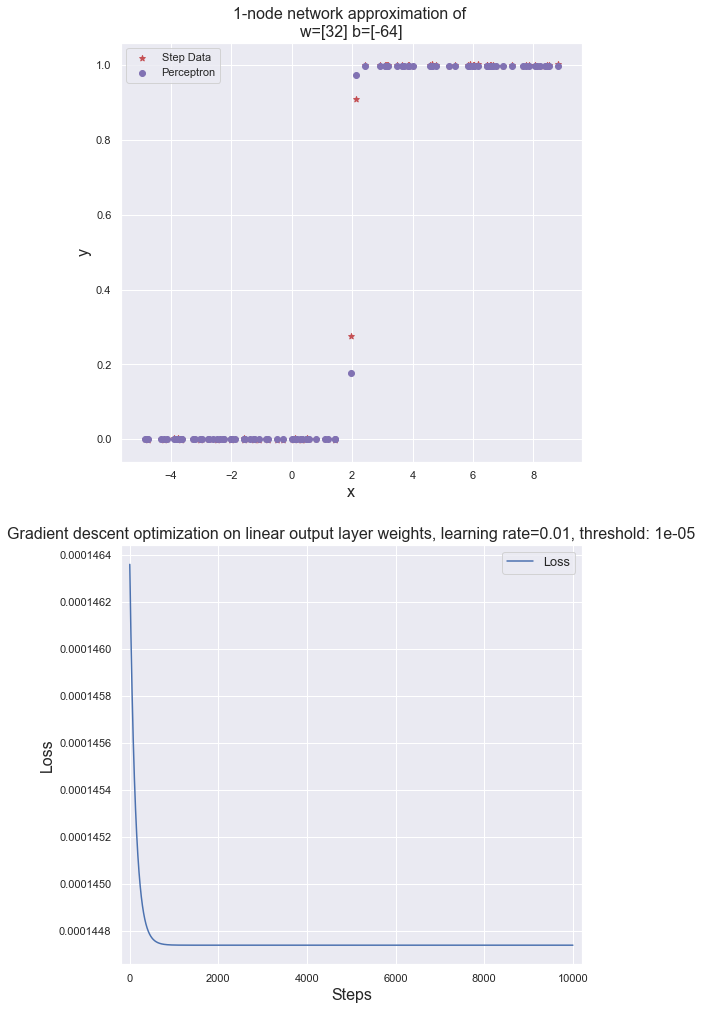

In [38]:
# step dataset / 1-node network : mse

fig, axes = setup_figure(2, 1)

## initial linear output weights
w_out0 = 1
b_out0 = 0
hidden_nodes = 1

## gradient descent parameters
learning_rate_ = 10**-2
threshold_ = 10**-4
max_iter_ = 10**4

show_opt_info(
    datasets[STEP_DATA].x, # x,
    datasets[STEP_DATA].y, # y,
    plot_step, # dataset_plot
    hidden_params[STEP_DATA]['w'], # ws,
    hidden_params[STEP_DATA]['h'], # bs,
    w_out0,
    b_out0,
    axes,
    "<em>{} vs Network Output</em><br/>".format(dataset_titles[STEP_DATA]) +
    "{}-node hidden layer (manually tuned weights)<br />".format(
        hidden_nodes) +
    "Linear output layer (optimized model MSE)", # title,
    learning_rate=learning_rate_,
    threshold=threshold_,
    max_iter=max_iter_,
    hidden_layer_size=hidden_nodes,
    plot_steps=True
)

At i = 1000 steps, it has not fallen beneath our threshold, but it is very close. Given the graph, it seems unlikely it will do so, so we may consider these  weights as close to the best we can do with these three methods.

### One Hump Dataset : 2-node network

Since the MSE seemed to be the best loss function for the Step Dataset, we will start with it, and run with a small number of steps.

,0
Steps,1000.000000
Network Loss,0.002956
Optimized b_out,-0.845112
Optimized w_out,0.888800
Threshold,0.000100
Learning Rate,0.010000


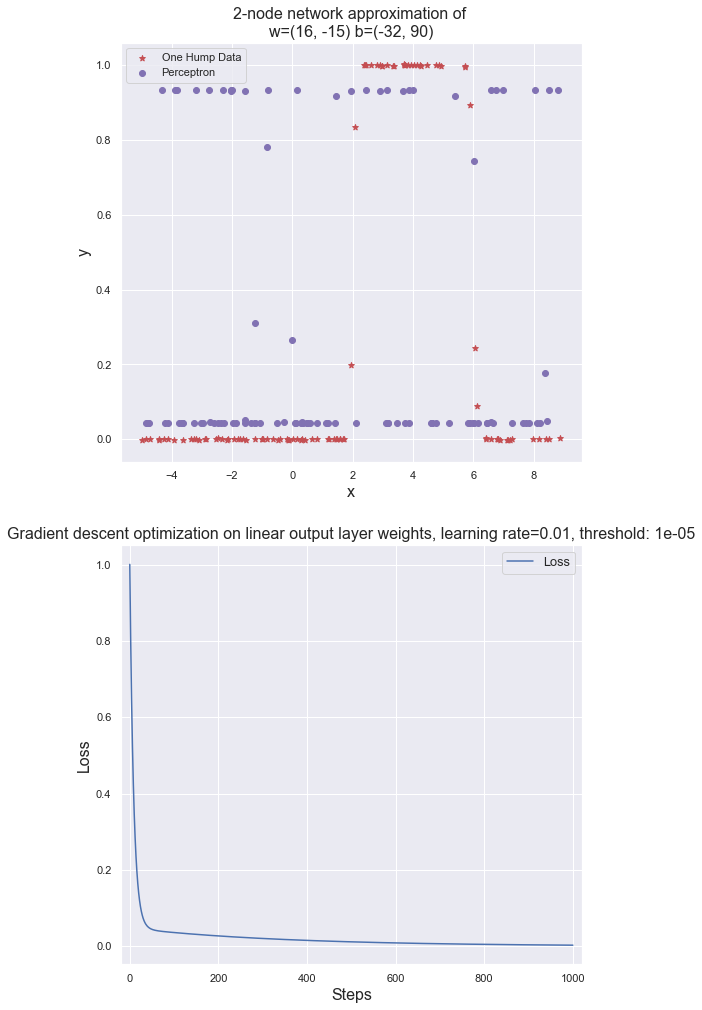

In [39]:
# one hump dataset / 2-node network

fig, axes = setup_figure(2, 1)

## initial linear output weights
w_out0 = 1
b_out0 = 0
hidden_nodes = 2

## gradient descent parameters
learning_rate_ = 10**-2
threshold_ = 10**-4
max_iter_ = 10**3

show_opt_info(
    datasets[ONE_HUMP_DATA].x, # x,
    datasets[ONE_HUMP_DATA].y, # y,
    plot_one_hump, # dataset_plot
    hidden_params[ONE_HUMP_DATA]['w'], # ws,
    hidden_params[ONE_HUMP_DATA]['h'], # bs,
    w_out0,
    b_out0,
    axes,
    "<em>{} vs Network Output</em><br/>".format(dataset_titles[ONE_HUMP_DATA]) +
    "{}-node hidden layer (manually tuned weights)<br />".format(hidden_nodes) +
    "Linear output layer (optimized model MSE)", # title,
    learning_rate=learning_rate_,
    threshold=threshold_,
    max_iter=max_iter_,
    hidden_layer_size=hidden_nodes,
    plot_steps=True
)

After 1000 steps, the MSE loss has shrunk significantly, but the predictions look very bad. We will try MAE next.

,0
Steps,1000.000000
Network Loss,941.931133
Optimized b_out,-21.384804
Optimized w_out,9.480861
Threshold,0.000100
Learning Rate,0.010000


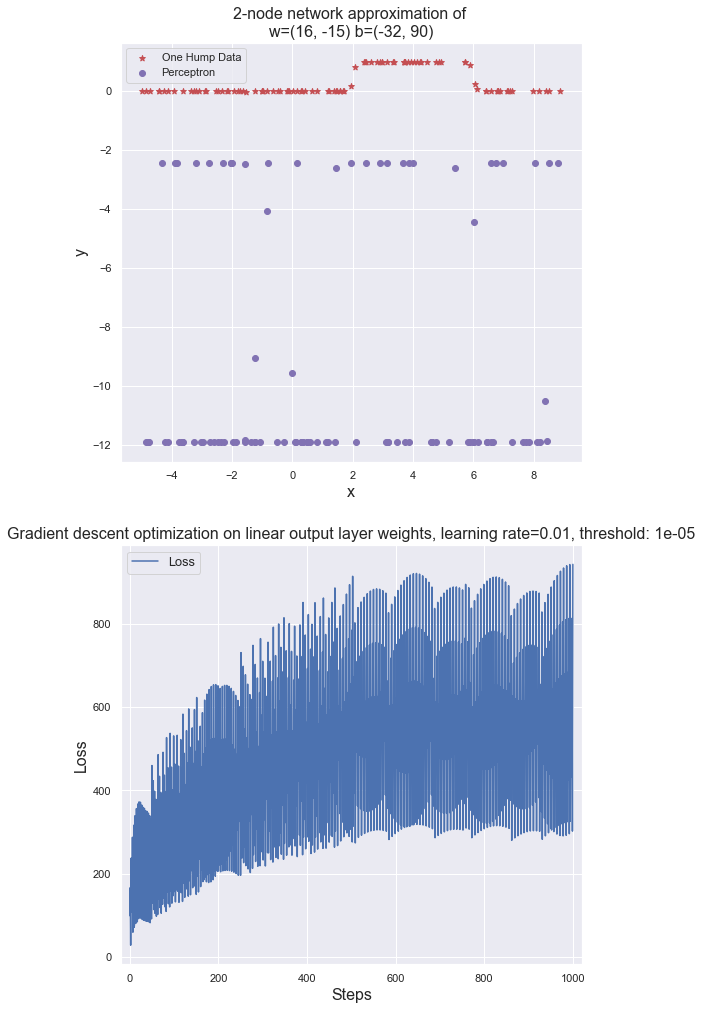

In [40]:
# one hump dataset / 2-node network

fig, axes = setup_figure(2, 1)

## initial linear output weights
w_out0 = 1
b_out0 = 0
hidden_nodes = 2

## gradient descent parameters
learning_rate_ = 10**-2
threshold_ = 10**-4
max_iter_ = 10**3

show_opt_info(
    datasets[ONE_HUMP_DATA].x, # x,
    datasets[ONE_HUMP_DATA].y, # y,
    plot_one_hump, # dataset_plot
    hidden_params[ONE_HUMP_DATA]['w'], # ws,
    hidden_params[ONE_HUMP_DATA]['h'], # bs,
    w_out0,
    b_out0,
    axes,
    "<em>{} vs Network Output</em><br/>".format(dataset_titles[ONE_HUMP_DATA]) +
    "{}-node hidden layer (manually tuned weights)<br />".format(hidden_nodes) +
    "Linear output layer (optimized model MAE)", # title,
    loss_function=mae,
    grad_function=grad_mae,
    learning_rate=learning_rate_,
    threshold=threshold_,
    max_iter=max_iter_,
    hidden_layer_size=hidden_nodes,
    plot_steps=True
)

MAE does not perform well with the predictions, and bizzarely, the loss seems to be trending upwards.

,0
Steps,1000.000000
Network Loss,14287.979858
Optimized b_out,-152.104054
Optimized w_out,-170.347783
Threshold,0.000100
Learning Rate,0.010000


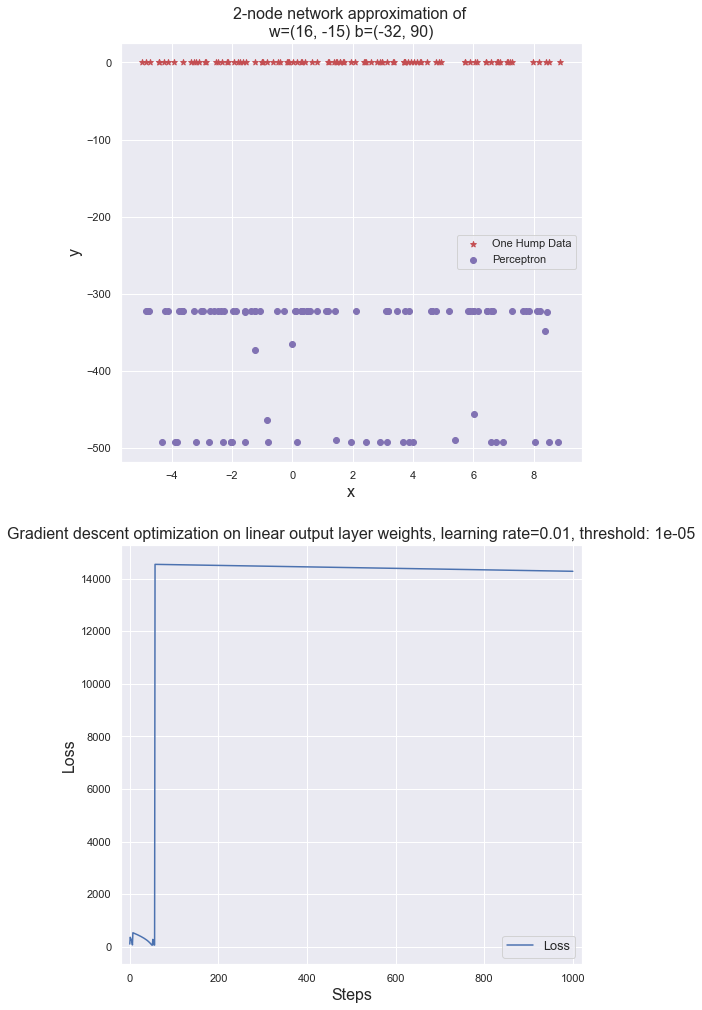

In [41]:
# one hump dataset / 2-node network

fig, axes = setup_figure(2, 1)

## initial linear output weights
w_out0 = 1
b_out0 = 0
hidden_nodes = 2

## gradient descent parameters
learning_rate_ = 10**-2
threshold_ = 10**-4
max_iter_ = 10**3

show_opt_info(
    datasets[ONE_HUMP_DATA].x, # x,
    datasets[ONE_HUMP_DATA].y, # y,
    plot_one_hump, # dataset_plot
    hidden_params[ONE_HUMP_DATA]['w'], # ws,
    hidden_params[ONE_HUMP_DATA]['h'], # bs,
    w_out0,
    b_out0,
    axes,
    "<em>{} vs Network Output</em><br/>".format(dataset_titles[ONE_HUMP_DATA]) +
    "{}-node hidden layer (manually tuned weights)<br />".format(hidden_nodes) +
    "Linear output layer (optimized model MAE)", # title,
    loss_function=sigmoid_log_loss,
    grad_function=grad_sigmoid_log_loss,
    learning_rate=learning_rate_,
    threshold=threshold_,
    max_iter=max_iter_,
    hidden_layer_size=hidden_nodes,
    plot_steps=True
)

The sigmoid-transformed log loss once again decreases slowly, but suddenly increases again and again with more steps. It doesn't seem to be useful.

Among our three loss function choices, none of them peformed very well. Although gradient descent seems to be working on minimizing MSE, it does not seem to correspond to meaningfully improved predictions.

### Two Hump: 4-node network

We will start by seeing how gradient descent does with MSE-loss in a small number of steps.

,0
Steps,1000.000000
Network Loss,0.087553
Optimized b_out,-0.552287
Optimized w_out,0.686541
Threshold,0.000010
Learning Rate,0.010000


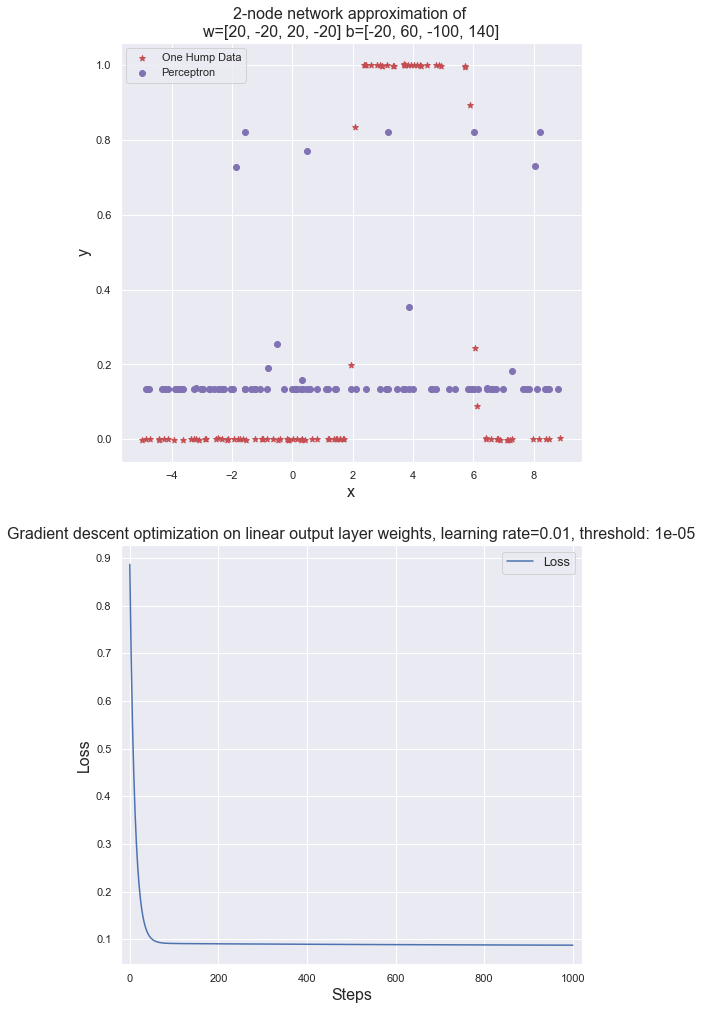

In [42]:
# two hump dataset / 4-node network

fig, axes = setup_figure(2, 1)

## initial linear output weights
w_out0_ = 1
b_out0_ = 0
hidden_nodes_ = 4
learning_rate_ = 10**-2
threshold_ = 10**-5
max_iter_ = 10**3

show_opt_info(
    datasets[TWO_HUMP_DATA].x, # x,
    datasets[TWO_HUMP_DATA].y, # y,
    plot_one_hump, # dataset_plot
    hidden_params[TWO_HUMP_DATA]['w'], # ws,
    hidden_params[TWO_HUMP_DATA]['h'], # bs,
    w_out0,
    b_out0,
    axes,
    "<em>{} vs Network Output</em><br/>".format(dataset_titles[TWO_HUMP_DATA]) +
    "{}-node hidden layer (manually tuned weights)<br />".format(hidden_nodes) +
    "Linear output layer (optimized model MSE)", # title,
    learning_rate=learning_rate_,
    threshold=threshold_,
    max_iter=max_iter_,
    hidden_layer_size=hidden_nodes,
    plot_steps=True
)


Again, minimizing MSE does not meaningfully improve the predictions. In the case of this data, the MSE might not be the right inverse measure of accuracy.

,0
Steps,1000.000000
Network Loss,1286.893490
Optimized b_out,-29.997949
Optimized w_out,16.240479
Threshold,0.000010
Learning Rate,0.010000


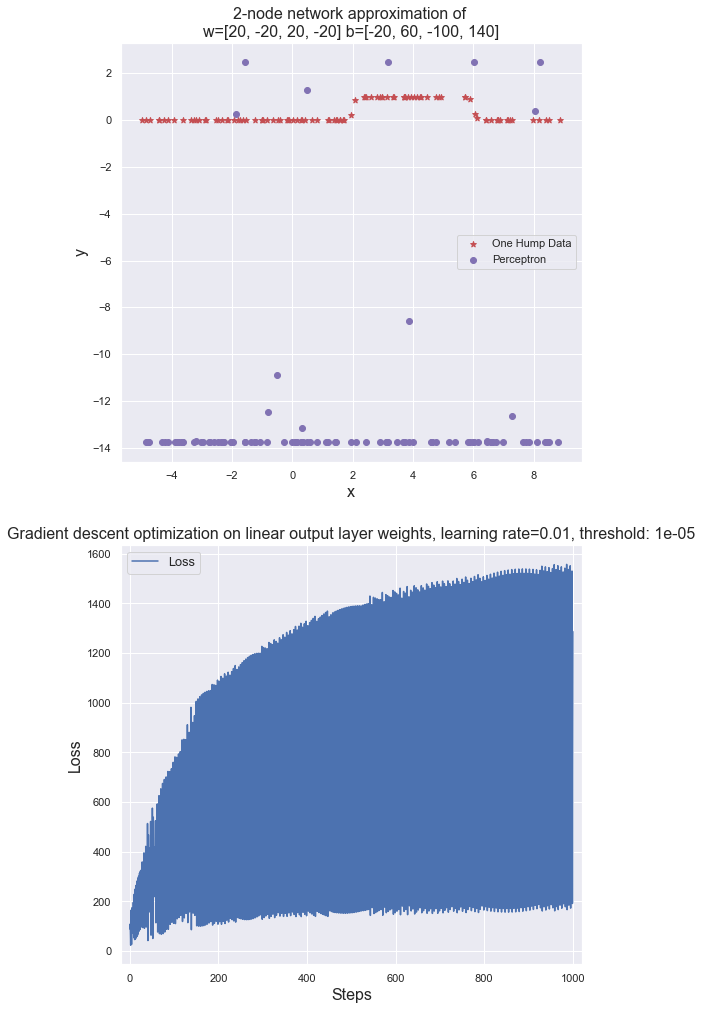

In [43]:
# two hump dataset / 4-node network

fig, axes = setup_figure(2, 1)

## initial linear output weights
w_out0_ = 1
b_out0_ = 0
hidden_nodes_ = 4
learning_rate_ = 10**-2
threshold_ = 10**-5
max_iter_ = 10**3

show_opt_info(
    datasets[TWO_HUMP_DATA].x, # x,
    datasets[TWO_HUMP_DATA].y, # y,
    plot_one_hump, # dataset_plot
    hidden_params[TWO_HUMP_DATA]['w'], # ws,
    hidden_params[TWO_HUMP_DATA]['h'], # bs,
    w_out0,
    b_out0,
    axes,
    "<em>{} vs Network Output</em><br/>".format(dataset_titles[TWO_HUMP_DATA]) +
    "{}-node hidden layer (manually tuned weights)<br />".format(hidden_nodes) +
    "Linear output layer (optimized model MSE)", # title,
    loss_function=mae,
    grad_function=grad_mae,
    learning_rate=learning_rate_,
    threshold=threshold_,
    max_iter=max_iter_,
    hidden_layer_size=hidden_nodes,
    plot_steps=True
)

,0
Steps,10000.000000
Network Loss,2732.037043
Optimized b_out,-63.039849
Optimized w_out,-65.596814
Threshold,0.000010
Learning Rate,0.010000


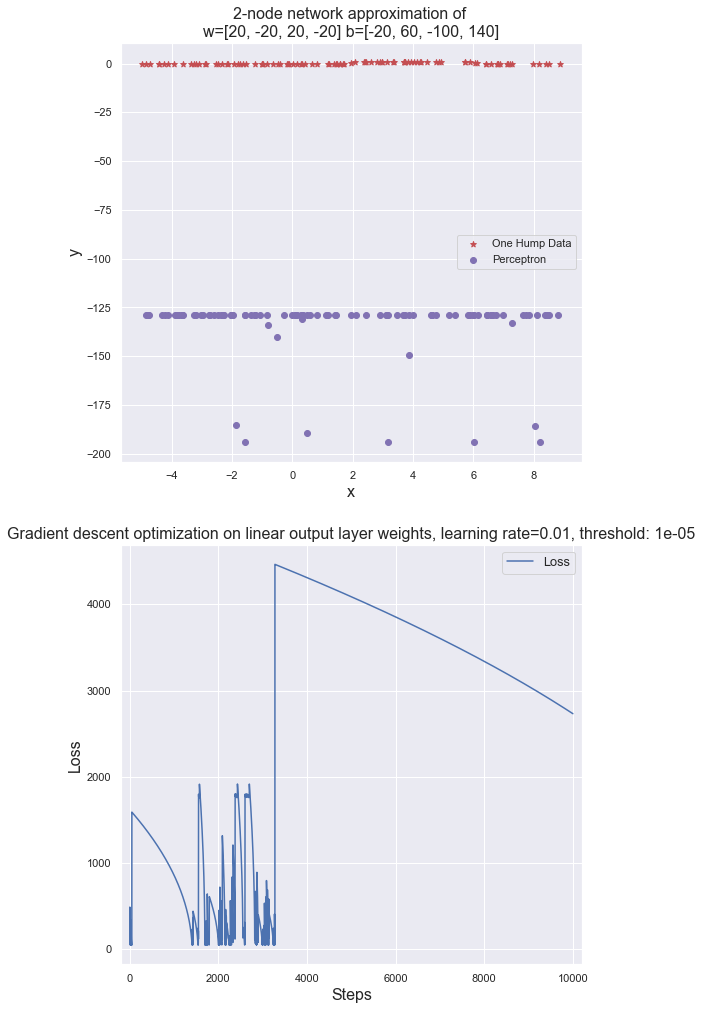

In [44]:
# two hump dataset / 4-node network

fig, axes = setup_figure(2, 1)

## initial linear output weights
w_out0_ = 1
b_out0_ = 0
hidden_nodes_ = 4
learning_rate_ = 10**-2
threshold_ = 10**-5
max_iter_ = 10**4

show_opt_info(
    datasets[TWO_HUMP_DATA].x, # x,
    datasets[TWO_HUMP_DATA].y, # y,
    plot_one_hump, # dataset_plot
    hidden_params[TWO_HUMP_DATA]['w'], # ws,
    hidden_params[TWO_HUMP_DATA]['h'], # bs,
    w_out0,
    b_out0,
    axes,
    "<em>{} vs Network Output</em><br/>".format(dataset_titles[TWO_HUMP_DATA]) +
    "{}-node hidden layer (manually tuned weights)<br />".format(hidden_nodes) +
    "Linear output layer (optimized model MSE)", # title,
    loss_function=sigmoid_log_loss,
    grad_function=grad_sigmoid_log_loss,
    learning_rate=learning_rate_,
    threshold=threshold_,
    max_iter=max_iter_,
    hidden_layer_size=hidden_nodes,
    plot_steps=True
)


None of the loss function choices were useful in gradient descent in these cases. For the MAE and the sigmoid-transformed log loss, further steps sometimes drastically increased the loss. They do not seem like reliable measures in the case of any of the datasets, and indeed we chose them for experimentation, without being clearly aware of their functional behavior, or the behavior of their derivatives.

Gradient descent with MSE loss worked the best with the single step data, the dataset that most closely resembled a linear response.

It is possible that a different transformation of inputs into log-loss, such as softmax log-loss, would have performed well in all three cases.

## Part 2: Working with missing data

In this part we are going to use the **Pima Indians onset of diabetes** dataset found in `pima-indians-diabetes.csv`. This dataset describes patient medical record data for Pima Indians and whether they had an onset of diabetes within five years. It is a binary classification problem (onset of diabetes as 1 or not as 0). The input variables that describe each patient are numerical and have varying scales. The list below shows the eight attributes plus the target variable for the dataset:

- Number of times pregnant.
- Plasma glucose concentration a 2 hours in an oral glucose tolerance test.
- Diastolic blood pressure (mm Hg).
- Triceps skin fold thickness (mm).
- 2-Hour serum insulin (mu U/ml).
-  Body mass index.
-  Diabetes pedigree function.
- Age (years).<br>
- **Outcome** (1 for early onset of diabetes within five years, 0 for not), target class.


**2.1**. Load the dataset into a pandas dataframe named `pima_df`. Clean the data by looking at the various features and making sure that their values make sense. Look for missing data including disguised missing data. The problem of disguised missing data arises when missing data values are not explicitly represented as such, but are coded with values that can be misinterpreted as valid data.

Let's first read the data into a dataframe and look at it.

In [46]:

pima_df = pd.read_csv('data/pima-indians-diabetes.csv')

In [47]:
pima_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000
mean,3.853403,120.922775,69.111257,20.537958,80.070681,31.998429,0.472712,33.248691
std,3.374327,32.039835,19.403339,15.970234,115.431087,7.899591,0.331981,11.771901
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.242500,24.000000
50%,3.000000,117.000000,72.000000,23.000000,34.000000,32.000000,0.375500,29.000000
75%,6.000000,141.000000,80.000000,32.000000,128.250000,36.600000,0.627500,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [48]:
display("The data has {} observations and {} features.".format(
    pima_df.shape[0],
    pima_df.shape[1]))

'The data has 764 observations and 9 features.'

In [49]:
response = 'Outcome'
predictors = pima_df.columns.difference([response]).values
print("The response variable is {}. \nThe predictors are: {}".format(
    response,
    predictors))

The response variable is Outcome. 
The predictors are: ['Age' 'BMI' 'BloodPressure' 'DiabetesPedigreeFunction' 'Glucose'
 'Insulin' 'Pregnancies' 'SkinThickness']


We immediately see strange values for some of the predictors. Pregnancies range up to 17. The blood pressure, glucose, skin thickness, insulin, and BMI variables include zeros, which are physically implausible. We will have to handle these somehow.

First, we will look at null and na values in the data.

In [50]:
pima_df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [240]:
pima_df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Although missing values are usually coded using NaN, Null, or None. It seems that none of the observations are clearly marked in this fashion.

Before we move on, let us look at possible interrelations between all the different variables.

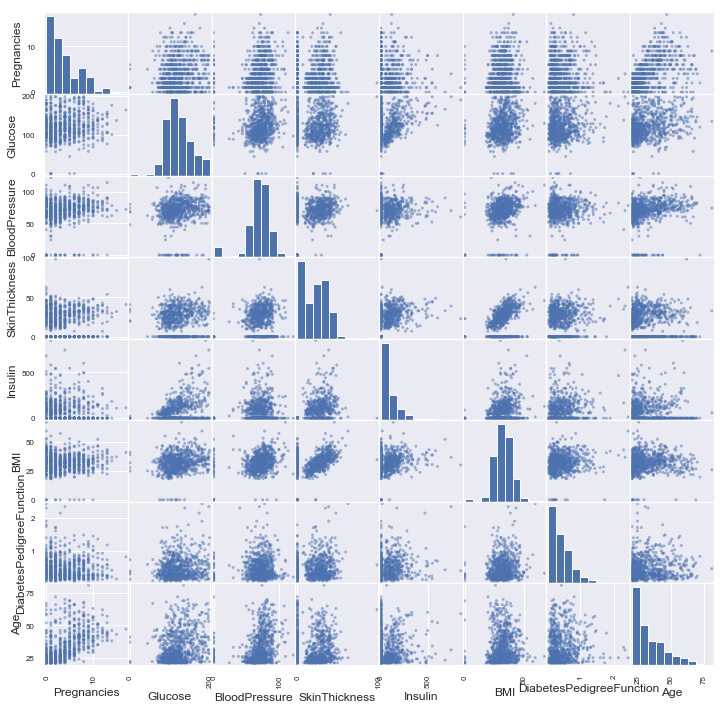

In [51]:
pd.plotting.scatter_matrix(pima_df, figsize=(12,12))
print("")

We note that SkinThinkness is strongly correlated to BMI. Insulin is positively correlated to Glucose level.

There is a counterintuitive pattern with pregnancies and age. We can look more closely with a 2D historgram.

Text(0, 0.5, 'Pregnancy Count')

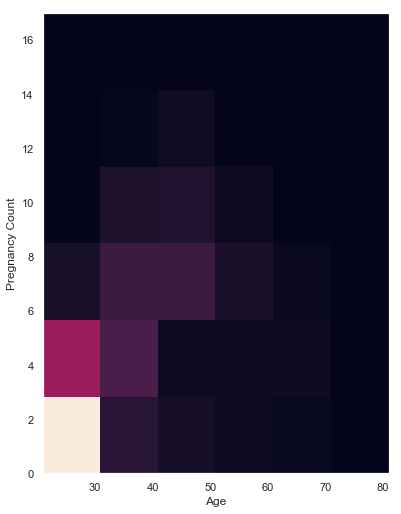

In [52]:
fig, ax = setup_figure(1, 1, 6, 4)

ax.hist2d(pima_df.Age, pima_df.Pregnancies, bins=6)
ax.set_xlabel("Age")
ax.set_ylabel("Pregnancy Count")

We would expect pregancy count to rise and remain high for higher ages, but instead we see that density is highest in the wengest age range, and that it drops. It is possible that pregnancies variable is coded incorrectly, or is measuring something completely different from cumulative pregnancies.

Although it makes the variable as descibed suspicious, it is likely a measurement or coding problem rather than a missing data issue.

We can turn the Pregnancies feature into a binary variable - 1 for having at least 1 pregnancy and 0 otherwise. By doing so it will be ambiguous how to interprete the value 0, which could either mean 'no pregnancy' or 'missing value'. We would loose the quantitative contribution of the count of pregnancies to the prediction of diabetes unset.  The same might happen if we choose to remove the Pregnancies feature completely.

We prefer to standardize the pregnancy values betwen 0 and 1 and thus keeping the original variance and improving regularized regression modeling later.

In terms of missing data, the variables we need to look at most closely are Glucose, BloodPressure, SkinThickness, Insulin, and BMI, all of which contain 0 among their observations.

A quick search in the litterature shows that these features cannot have a physiological value of zero. The most plausible explanation is that mssing observations for features were missing were somehow replaced with zero. 

This disguised missing data would mislead our later classification attempts. We will clean the data by marking disguised missing values clearly as NaN. 


The response variable, which should be coded as 0 or 1, contained values with \ or } appended to the 0's and 1s. It looks like an error similar to those introduced when reading from or writing CSVs have found their way into the data. The solution we choose is simply to remove the characters.

Looking at the data types, predictors are stored as float and the response as an object. The float data type makes sense for BMI and DiabetesPedigreeFunction. The remaining features can be stored as integers.

In [277]:
pima_df.Pregnancies.unique()

array([ 6,  1,  8,  0,  5,  3, 10,  2,  4,  7,  9, 11, 13, 15, 17, 12, 14])

The following function cleans the data and replaces zeros with NaNs for the five columns discussed: `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, and `BMI`.

In [53]:
def clean_data(df_raw, 
               cols_with_zeros=['Glucose', 'BloodPressure',
                                'SkinThickness', 'Insulin', 'BMI'], 
               response = ['Outcome']):
    df = df_raw.copy()
    # replace zero with NaN in features
    df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)
    # remove \ and } from response
    df = df.replace(to_replace=r'\\|\}', value='', regex=True)
    # change response data type to int
    df[response] = df[response].astype('int')
    return df

Let's test our code for data cleaning. Below are the first few rows of observations for illustration. We have replaced any zero we have deciced that actually indicate missing values with NaN.

In [54]:
pima_df_cleaned = clean_data(pima_df)
pima_df_cleaned.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


We can calculate the proportion of missing values for each feature. 48.56% of Insulin, 29.58% of SkinThickness, 4.58% of BloodPressure, 1.43% of BMI and 0.65% of Glucose. The remaining features do not have any missing values. 

In [55]:
print("Proportion of missing values")
missing_values_count = (pima_df_cleaned.isna().sum()*100 /
                        pima_df_cleaned.shape[0])
missing_values_count

Proportion of missing values


Pregnancies                  0.000000
Glucose                      0.654450
BloodPressure                4.581152
SkinThickness               29.581152
Insulin                     48.560209
BMI                          1.439791
DiabetesPedigreeFunction     0.000000
Age                          0.000000
Outcome                      0.000000
dtype: float64

In [56]:
features_with_missing_values = missing_values_count[
    missing_values_count>0].index.values
features_with_missing_values

array(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'],
      dtype=object)

By looking closer, it seems that missing values for SkinThickness are correlated with missing values for Insulin. When SkinThickness is missing, then Insulin is also missing.  

Furthermore when BloodPressure or BMI is missing, then the probability is higher that Insulin or SkinThickness values will be missing as well.

We might need to perform some statistical tests of the hypothesis that the features are Missing at Random (MAR), Missing Completely at Random (MCAR) or Missing not at Random (MNAR).


In [57]:
pima_df[(pima_df.SkinThickness==0) & (pima_df.Insulin!=0)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [58]:
pima_df_cleaned[pima_df_cleaned.Insulin.isna()].head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
5,5,116.0,74.0,NaN,NaN,25.6,0.201,30,0
7,10,115.0,NaN,NaN,NaN,35.3,0.134,29,0


**2.2** Split the dataset into a 75-25 train-test split (use `random_state=9001`). Fit a logistic regression classifier to the training set and report the  accuracy of the classifier on the test set. We should use $L_2$ regularization in logistic regression, with the regularization parameter tuned using cross-validation (`LogisticRegressionCV`).  Report the overall classification rate.

In the previous section we clearly marked missing data with NaN.

We can now either drop or impute those missing data. The function below can do either, and also supports mean and model-based imputation using KNN regression.

In [59]:
# function for KNN model-based imputation of missing values using features without NaN as predictors
def impute_model_basic(df):
  cols_nan = df.columns[df.isna().any()].tolist()    
  cols_no_nan = df.columns.difference(cols_nan).values            
  for col in cols_nan:
      test_data = df[df[col].isna()]
      train_data = df.dropna()
      knr = KNeighborsRegressor(n_neighbors=5).fit(
          train_data[cols_no_nan],
          train_data[col])
      df.loc[df[col].isna(), col] = knr.predict(test_data[cols_no_nan])
  return df

# function for KNN model-based imputation of missing values using features without NaN as predictors, including progressively added imputed features
def impute_model_progressive(df):
  cols_nan = df.columns[df.isna().any()].tolist()    
  cols_no_nan = df.columns.difference(cols_nan).values            
  while len(cols_nan)>0:
      col = cols_nan[0]
      test_data = df[df[col].isna()]
      train_data = df.dropna()
      knr = KNeighborsRegressor(n_neighbors=5).fit(
          train_data[cols_no_nan], train_data[col])
      df.loc[df[col].isna(), col] = knr.predict(test_data[cols_no_nan])
      cols_nan = df.columns[df.isna().any()].tolist()    
      cols_no_nan = df.columns.difference(cols_nan).values
  return df

# function for imputing missing data according to a given impute_strategy:
#  drop_rows: drop all rows with one or more missing values
#  drop_cols: drop columns with one or more missing values
#  model_basic: KNN-model-based imputation with fixed predictors
#  model_progressive: KNN-model-based imputation with
#   progressively added predictors
#  mean, median, most_frequent: imputation with mean, median
#   or most frequent values
#
#  cols_to_standardize: if provided, the specified columns are scaled
#   between 0 and 1, after imputation
def impute_data(df_cleaned, impute_strategy=None, cols_to_standardize=None):
    df = df_cleaned.copy()
    if impute_strategy == 'drop_rows':
      df = df.dropna(axis=0)
    elif impute_strategy == 'drop_cols':
      df = df.dropna(axis=1)
    elif impute_strategy == 'model_basic':
      df = impute_model_basic(df)
    elif impute_strategy == 'model_progressive':
      df = impute_model_progressive(df) 
    else:
      # print("impute strategy: ".format(impute_strategy))
      arr = SimpleImputer(missing_values=np.nan,
                          strategy=impute_strategy).fit(
                              df.values).transform(df.values)
      df = pd.DataFrame(data=arr, index=df.index.values,
                        columns=df.columns.values)
      # print(df_cleaned.columns.difference(df.columns))
    if cols_to_standardize != None:
      cols_to_standardize = list(set(cols_to_standardize) & set(df.columns.values))
      df[cols_to_standardize] = df[cols_to_standardize].astype('float')
      df[cols_to_standardize] = pd.DataFrame(data=MinMaxScaler().fit(
          df[cols_to_standardize]).transform(df[cols_to_standardize]), 
                                 index=df[cols_to_standardize].index.values,
                                 columns=df[cols_to_standardize].columns.values)
      # print("After standardization: ", df_cleaned.columns.difference(df.columns))
    return df

The drop strategy remove all observations where at least one of the features has a missing value (NaN). 

The mean strategy replace any missing value (NaN) by the mean of all values available for that feature.

The model-based strategy uses the features without missing values for training KNN regression models. We choose KNN in order to capture the variability of available data. This would not be the case if we would use a linear regression model that would predict missing values along a regression line. We distinguish between two modes in this model-based strategy. The following features are used as predictors in the basic mode: Age, DiabetesPedigreeFunction, Outcome, Pregnancies. The fitted model are used to predict the missing values in the remaining features. In the progressive mode, after we fill in missing values in a given feature, we consider the feature as a predictor for estimating the missing values of the next feature.

The imputed data can be optionaly standardized between 0 and 1. This might improved the performance of classification using regularized logistic regression. Because the features are on different scale (e.g. Age vs Insulin) and their values range differs (e.g. Pedigree vs Insulin), shrinkage penalty could be wrongly calculated.

### Logistic Regression

The following function fits a logistic regression model on the cleaned data after applying a given imputation strategy: drop rows missing values, impute missing values with column mean, impute missing values with model-based prediction.

In [60]:
def logistic_regression(data, impute_strategy=None,
                        cols_to_standardize=None,
                        test_size=0.25,
                        random_state=9001):
    start = timer()
    
    # store original columns
    original_columns = data.columns.difference(['Outcome'])
    df_imputed = impute_data(data, impute_strategy, cols_to_standardize)
    train_data, test_data = train_test_split(df_imputed, test_size=test_size,
                                             random_state=random_state)
    
    # note which predictor columns were dropped or kept
    kept_columns = df_imputed.columns.difference(['Outcome'])
    dropped_columns = original_columns.difference(df_imputed.columns)
    original_columns = original_columns.difference(['Outcome'])

    X_train = train_data.drop(columns=['Outcome'])
    y_train = train_data['Outcome']
    X_test = test_data.drop(columns=['Outcome'])
    y_test = test_data['Outcome']
    logistic_model = LogisticRegressionCV(cv=10, penalty='l2', max_iter=1000).fit(
        X_train, y_train)
    train_score = accuracy_score(y_train, logistic_model.predict(X_train))
    test_score = accuracy_score(y_test, logistic_model.predict(X_test))
    duration = timer() - start
    print("Classification rate on training data: {}".format(train_score))
    print("Classification rate on test data: {}".format(test_score))
    print("Execution time: {}".format(duration))
    return {
        'imputation strategy': impute_strategy,
        'standardized': cols_to_standardize!=None,
        'model': logistic_model,
        'train score': train_score,
        'test score': test_score,
        'execution time (s)': duration,
        # '_columns' : [original_columns, kept_columns, dropped_columns]
    }

Let's fit a logistic regression model on the cleaned data after **dropping rows with missing values** and **without  and with standardizing** predictors. 

In [74]:
lr_results = []
pima_df_cleaned = clean_data(pima_df)
result = logistic_regression(pima_df_cleaned,
                             impute_strategy='drop_rows',
                             cols_to_standardize=None)
lr_results.append(result)

Classification rate on training data: 0.8225255972696246
Classification rate on test data: 0.7040816326530612
Execution time: 2.4627429752877106


In [75]:
cols_to_standardize=['Age','BMI','BloodPressure','Glucose',
                     'Insulin','Pregnancies','SkinThickness',
                     'DiabetesPedigreeFunction']
result = logistic_regression(pima_df_cleaned,
                             impute_strategy='drop_rows',
                             cols_to_standardize=cols_to_standardize)
lr_results.append(result)

Classification rate on training data: 0.825938566552901
Classification rate on test data: 0.6938775510204082
Execution time: 0.5853218328585399


We also fit a logistic regression model on the cleaned data after **dropping columns with missing values** and **without  and with standardizing** predictors. 

In [76]:
result = logistic_regression(pima_df_cleaned,
                             impute_strategy='drop_cols',
                             cols_to_standardize=None)
lr_results.append(result)

Classification rate on training data: 0.6614310645724258
Classification rate on test data: 0.6649214659685864
Execution time: 0.7123663002985268


In [77]:
result = logistic_regression(pima_df_cleaned,
                             impute_strategy='drop_cols',
                             cols_to_standardize=cols_to_standardize)
lr_results.append(result)

Classification rate on training data: 0.6614310645724258
Classification rate on test data: 0.675392670157068
Execution time: 0.48889663400871086


Dropping columns with missing value produces the worse classification accuracy score and would not be wise to do if we care about prediction performance when detecting the onset of diabetes. Dropping rows with missing values provides better prediction, but as we see in the next section, imputation is highly recommended instead. Standardizing features in the scale 0 to 1 has a slightly negative impact on test accuracy score. Looking at the coefficients we gain in better interpretability after standardizing.

**2.3** Restart with a fresh copy of the whole dataset and impute the missing data via mean imputation.  Split the data 75-25 (use `random_state=9001`) and fit a regularized logistic regression model.  Report the overall classification rate.  

Let's now fit a logistic regression model on the cleaned data after **imputing missing values with their feature's mean** and **without standardizing predictors**.

In [78]:
pima_df_cleaned = clean_data(pima_df)
result = logistic_regression(pima_df_cleaned,
                             impute_strategy='mean',
                             cols_to_standardize=None)
lr_results.append(result)

Classification rate on training data: 0.7713787085514834
Classification rate on test data: 0.7591623036649214
Execution time: 2.2877041254586175


Next we fit a logistic regression model on the cleaned data after **imputing missing values with their feature's mean** and **with standardizing predictors**.

In [79]:
pima_df_cleaned = clean_data(pima_df)
result = logistic_regression(pima_df_cleaned,
                             impute_strategy='mean',
                             cols_to_standardize=cols_to_standardize)
lr_results.append(result)

Classification rate on training data: 0.7661431064572426
Classification rate on test data: 0.7591623036649214
Execution time: 0.6255817193240318


**2.4** Again restart with a fresh copy of the whole dataset and impute the missing data via a model-based imputation method. Once again split the data 75-25 (same `random_state=9001`) and fit a regularized logistic regression model.  Report the overall classification rate.

Here we fit a logistic regression model on the cleaned data after **imputing missing values with predictions made by a KNN regression model** in the **basic mode** and **without and with standardizing predictors**.

In [80]:
pima_df_cleaned = clean_data(pima_df)
result = logistic_regression(pima_df_cleaned,
                             impute_strategy='model_basic',
                             cols_to_standardize=None)
lr_results.append(result)

Classification rate on training data: 0.7696335078534031
Classification rate on test data: 0.7801047120418848
Execution time: 2.7037219241550474


In [81]:
pima_df_cleaned = clean_data(pima_df)
result = logistic_regression(pima_df_cleaned,
                             impute_strategy='model_basic',
                             cols_to_standardize=cols_to_standardize)
lr_results.append(result)

Classification rate on training data: 0.7713787085514834
Classification rate on test data: 0.774869109947644
Execution time: 0.598948959832228


Finally we fit a logistic regression model on the cleaned data after **imputing missing values with predictions made by a KNN regression model** in the **progressive mode** and **with and without standardizing predictors**.

In [82]:
result = logistic_regression(pima_df_cleaned,
                             impute_strategy='model_progressive',
                             cols_to_standardize=None)
lr_results.append(result)

Classification rate on training data: 0.7818499127399651
Classification rate on test data: 0.7696335078534031
Execution time: 2.5954266438631066


In [83]:
result = logistic_regression(pima_df_cleaned,
                             impute_strategy='model_progressive',
                             cols_to_standardize=cols_to_standardize)
lr_results.append(result)

Classification rate on training data: 0.7853403141361257
Classification rate on test data: 0.774869109947644
Execution time: 0.5804017969363713


**2.5** Compare the results in the 3 previous parts of this problem. Discuss the results, the computational complexity of the methods,  and explain why we get the results that we see.

We recall the classification accuracy scores obtained on train and test datasets when using different missing data handling strategies in the table below.  

In [84]:
lr_results_df_full = pd.DataFrame(lr_results)
lr_results_df = lr_results_df_full.copy()
lr_results_df.drop(['model'], axis=1).drop_duplicates()

,execution time (s),imputation strategy,standardized,test score,train score
0,2.462743,drop_rows,False,0.704082,0.822526
1,0.585322,drop_rows,True,0.693878,0.825939
2,0.712366,drop_cols,False,0.664921,0.661431
3,0.488897,drop_cols,True,0.675393,0.661431
4,2.287704,mean,False,0.759162,0.771379
5,0.625582,mean,True,0.759162,0.766143
6,2.703722,model_basic,False,0.780105,0.769634
7,0.598949,model_basic,True,0.774869,0.771379
8,2.595427,model_progressive,False,0.769634,0.781850
9,0.580402,model_progressive,True,0.774869,0.785340


By dropping rows or columns with missing values we lose valuable information that might have significant impact on the response variable. The consequence is overfitting in the training dataset and bad prediction performance on test. 

Mean imputation of missing data reduces overfitting and improves the prediction on test data. Classification is the best when a model-based is used when imputing missing data. This is because the original variance of the data is better approached when using k-nearest neighbors as a replacement of missing data. 

The computational complexity is assessed by measuring the cummulative execution time of imputation, logistic regression model fitting and prediction. The execution time for the model-based approach is the highest when predictors are not standardized. Calculating eucliding distance to nearest neighbors requires more execution time than claculating the mean of data. When dealing with a very large number of observations, we might prefer mean imputation at the cost of lower classification accuracy.

**2.6** Check which coefficients changed the most between the model in 2.1-2.2 and the models in 2.3 and 2.4. Are they the coefficients we expected to change given the imputation we performed?

We retrieve the coefficients estimated by our three regularized logistic regression models as follows:

In [85]:
# get index of strategies
strategies = lr_results_df['imputation strategy']

# get a boolean array where True => standardized
standardized = lr_results_df['standardized']
st = lambda s: ' standardized' if s else ''
coefs_ = {}
for key, value in enumerate(strategies):
  if value == 'drop_cols':
    # skip
    pass
  else:
    strategy = value + st(standardized[key])
    coefs_[strategy] = lr_results_df['model'][key].coef_[0]
coef_df = pd.DataFrame(data=coefs_, index=predictors)
coef_df.T

,Age,BMI,BloodPressure,DiabetesPedigreeFunction,Glucose,Insulin,Pregnancies,SkinThickness
drop_rows,0.042564,0.045167,0.005971,-0.001468,-0.002139,0.082863,0.886278,0.031732
drop_rows standardized,0.735311,6.392340,0.557511,-0.076818,-1.753759,4.023227,2.227853,1.886078
mean,0.152737,0.039351,-0.010044,-0.008100,-0.000722,0.104920,0.970776,0.015417
mean standardized,2.518618,5.928043,-0.840873,-0.511482,-0.450867,4.821598,2.280943,0.915084
model_basic,0.149819,0.038735,-0.007930,0.000360,-0.000341,0.096889,0.966449,0.014798
model_basic standardized,2.544424,5.990275,-0.754651,0.054290,-0.275555,4.704325,2.339019,0.885454
model_progressive,0.151583,0.041286,-0.012678,-0.000481,-0.001409,0.102210,0.968407,0.015706
model_progressive standardized,2.574147,6.390805,-1.204183,-0.023087,-1.159256,4.978973,2.373463,0.946132


The following table compares the effect of mean imputation and model-based imputation on the coefficient magnitude obtained after dropping rows with missing data.

In [86]:
coef_perc_df = coef_df.copy()
cols = coef_df.columns.difference(['drop_rows']).values
for col in cols:
  coef_perc_df[col] = np.round(100*(coef_df[col] /
                                    coef_df['drop_rows']-1))
coef_perc_df[['drop_rows','mean','model_basic','model_progressive']]

,drop_rows,mean,model_basic,model_progressive
Age,0.042564,259.0,252.0,256.0
BMI,0.045167,-13.0,-14.0,-9.0
BloodPressure,0.005971,-268.0,-233.0,-312.0
DiabetesPedigreeFunction,-0.001468,452.0,-125.0,-67.0
Glucose,-0.002139,-66.0,-84.0,-34.0
Insulin,0.082863,27.0,17.0,23.0
Pregnancies,0.886278,10.0,9.0,9.0
SkinThickness,0.031732,-51.0,-53.0,-51.0


The first column shows the coefficient estimates for the logistic model trained on data where rows with missing values where removed. The second row shows the percentage change of coefficients values using a logistic classification model on the data after mean imputation compared to the first model. The last two columns show the  percentage change when KNN model-based imputation is used.

Additionally, we can come to the following conclusions:

*   There is no obvious correlation between Age, BloodPressure and DiabetesPedigreeFunction and the onset of diabetes. When mean or model-based imputation is used, the coefficient estimates for Age, BloodPressure and DiabetesPedigreeFunction change drastically, compared to their values when missing data is simply dropped.

*   Coefficients for Insulin do not vary much between imputation methods. This suggest that Insulin might be Missing Completely At Random (MCAR).

